In [1]:
!pip install xarray

import sys
import os

import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime
from datetime import datetime, timedelta

import deep_soil_utils as ds
from deep_soil_utils import *

# This allows us to import tools from the dvm-dos-tem/scripts directory
sys.path.insert(0, '/work/scripts')
import output_utils as ou
from output_utils import load_trsc_dataframe #loads transient and scenario data, columns are layers
from output_utils import stitch_stages
#need to aggregate by year?
# ds = nc.Dataset("/data/workflows/MD_deep_soil/experiment/output/TLAYER_monthly_sc.nc") 

# This lets us work with shorter paths relative to the experiment directory
# os.chdir('/data/workflows/MD_deep_soil/control')


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


# MD and BNZ, CMT1

For MD with cmt 1 there are 4 pfts - 

Deep Soil Branch: Mineral column increased from 15 to 46 layers / 5m to 50m (the deep soil branch, experiment results)

In deep soil branch, the mineral column is layers 3-48
In master branch, it is layers 3-19
(see LAYERTYPE var)

### No DSL:
DSL = dynamic soil layering module
This module contains the set of equations that relate C stocks to layer thickness. If C stocks are too small in a given layer, they may be merged with other layers - this causes the layers to be reordered. Turning off the dsl module removes the appearance of spikes in the layerdepth data

##### To Turn off DSL: 
    - change all instances of runner.cohort.md->set_dslmodule(true);  to runner.cohort.md->set_dslmodule(false);  in TEM.cpp in the src directory - and then recompile.
    - layer thicknesses should then match the values in the parameter files cmt_dimground.txt
    
NOTE: Model runs with DSL turned off are tagged "nodsl" in the workflow folder name

## Questions:

Comparison for seasonal temp by layer shows little difference between deep soil and master branches

Maybe calculate variance and std by year - see google colab. 

In [6]:
#scripts
!ls /work/deep_soil_runs

Layer_var_synth.py	     deep_soil_experiment.sh
Output_synthesis_Valeria.sh  output_spec.csv


In [4]:
!ncdump -h /data/workflows/MD_deep_soil/experiment_allout_monthly_11px/output/restart-tr.nc

netcdf restart-tr {
dimensions:
	Y = 10 ;
	X = 10 ;
	pft = 10 ;
	pftpart = 3 ;
	snowlayer = 6 ;
	rootlayer = 10 ;
	soillayer = 53 ;
	rocklayer = 5 ;
	fronts = 10 ;
	prevten = 10 ;
	prevtwelve = 12 ;
variables:
	int dsr(Y, X) ;
		dsr:_FillValue = -9999 ;
	int numsl(Y, X) ;
		numsl:_FillValue = -9999 ;
	int numsnwl(Y, X) ;
		numsnwl:_FillValue = -9999 ;
	int rtfrozendays(Y, X) ;
		rtfrozendays:_FillValue = -9999 ;
	int rtunfrozendays(Y, X) ;
		rtunfrozendays:_FillValue = -9999 ;
	int yrsdist(Y, X) ;
		yrsdist:_FillValue = -9999 ;
	double firea2sorgn(Y, X) ;
		firea2sorgn:_FillValue = -9999. ;
	double snwextramass(Y, X) ;
		snwextramass:_FillValue = -9999. ;
	double monthsfrozen(Y, X) ;
		monthsfrozen:_FillValue = -9999. ;
	double watertab(Y, X) ;
		watertab:_FillValue = -9999. ;
	double wdebrisc(Y, X) ;
		wdebrisc:_FillValue = -9999. ;
	double wdebrisn(Y, X) ;
		wdebrisn:_FillValue = -9999. ;
	int ifwoody(Y, X, pft) ;
		ifwoody:_FillValue = -9999 ;
	int ifdeciwoody(Y, X, pft) ;
		ifdeciw

In [137]:
!ls /data/workflows/BNZ_deep_soil/control_allout_monthly_11px/output

ALD_yearly_sc.nc	  LAYERTYPE_monthly_sc.nc      TDEEP_monthly_sp.nc
ALD_yearly_sp.nc	  LAYERTYPE_monthly_sp.nc      TDEEP_monthly_tr.nc
ALD_yearly_tr.nc	  LAYERTYPE_monthly_tr.nc      TLAYER_monthly_sc.nc
DEEPC_monthly_sc.nc	  LWCLAYER_monthly_sc.nc       TLAYER_monthly_sp.nc
DEEPC_monthly_sp.nc	  LWCLAYER_monthly_sp.nc       TLAYER_monthly_tr.nc
DEEPC_monthly_tr.nc	  LWCLAYER_monthly_tr.nc       TMINEA_monthly_sc.nc
DEEPDZ_yearly_sc.nc	  MINEC_monthly_sc.nc	       TMINEA_monthly_sp.nc
DEEPDZ_yearly_sp.nc	  MINEC_monthly_sp.nc	       TMINEA_monthly_tr.nc
DEEPDZ_yearly_tr.nc	  MINEC_monthly_tr.nc	       TMINEB_monthly_sc.nc
EET_monthly_sc.nc	  PET_monthly_sc.nc	       TMINEB_monthly_sp.nc
EET_monthly_sp.nc	  PET_monthly_sp.nc	       TMINEB_monthly_tr.nc
EET_monthly_tr.nc	  PET_monthly_tr.nc	       TMINEC_monthly_sc.nc
GPP_yearly_sc.nc	  RH_monthly_sc.nc	       TMINEC_monthly_sp.nc
GPP_yearly_sp.nc	  RH_monthly_sp.nc	       TMINEC_monthly_tr.nc
GPP_yearly_tr.nc	  RH_monthly_tr.nc	       

## ALD for pixel 0,0

Trying to open:  output/ALD_yearly_tr.nc
Trying to open:  output/ALD_yearly_sc.nc
Trying to open:  output/ALD_yearly_tr.nc
Trying to open:  output/ALD_yearly_sc.nc


Text(0.5, 1.0, 'Deep Soil branch')

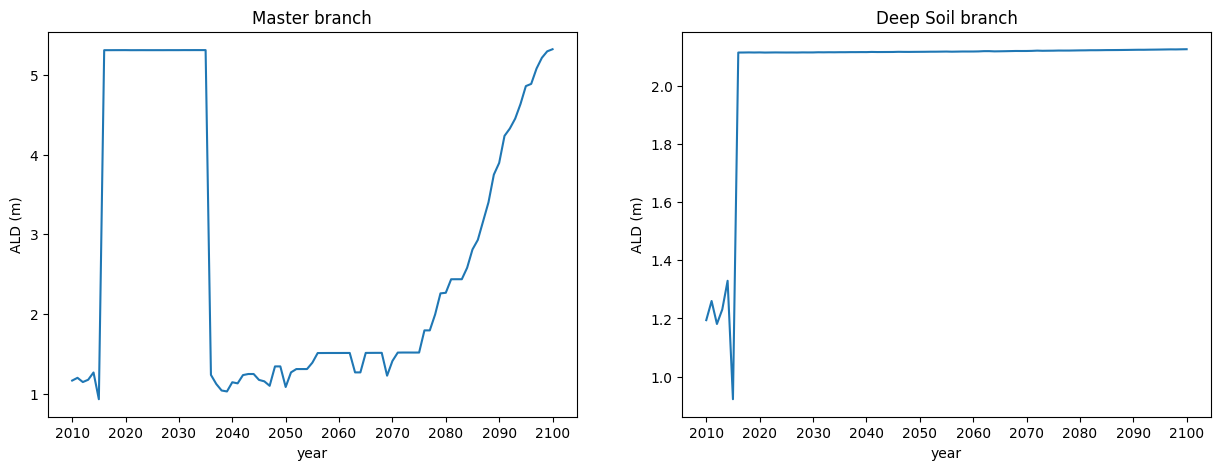

In [107]:
#PLOT ALD

#OLD COEFFICIENTS FOR CMT1
fig, ax = plt.subplots(1,2,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control')
df, meta = load_trsc_dataframe(var='ALD', timeres='yearly', px_y=0, px_x=0, fileprefix='output')
ax[0].plot(df.loc['2010':'2100'].index, df.loc['2010':'2100'][0], label='ALD')
ax[0].set_xlabel('year')
ax[0].set_ylabel('ALD ({})'.format(meta['var_units']))
ax[0].set_title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment')
df, meta = load_trsc_dataframe(var='ALD', timeres='yearly', px_y=0, px_x=0, fileprefix='output')
ax[1].plot(df.loc['2010':'2100'].index, df.loc['2010':'2100'][0], label='ALD')
ax[1].set_xlabel('year')
ax[1].set_ylabel('ALD ({})'.format(meta['var_units']))
ax[1].set_title('Deep Soil branch')

Trying to open:  output/ALD_yearly_tr.nc
Trying to open:  output/ALD_yearly_sc.nc
Trying to open:  output/ALD_yearly_tr.nc
Trying to open:  output/ALD_yearly_sc.nc


Text(0.5, 1.0, 'Deep Soil branch')

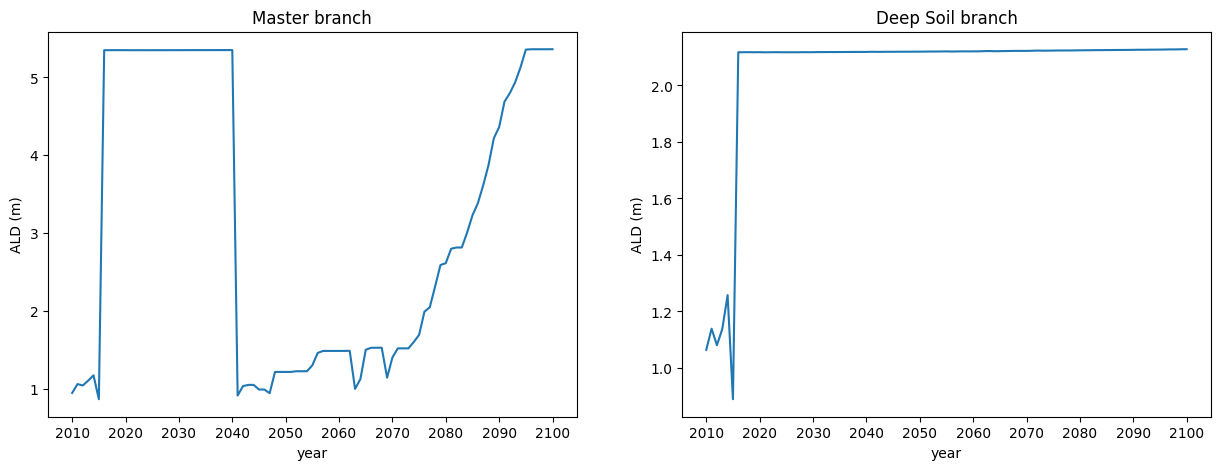

In [107]:
#PLOT ALD

#NEW COEFFICIENTS FOR CMT1
fig, ax = plt.subplots(1,2,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px')
df, meta = load_trsc_dataframe(var='ALD', timeres='yearly', px_y=1, px_x=1, fileprefix='output')
ax[0].plot(df.loc['2010':'2100'].index, df.loc['2010':'2100'][0], label='ALD')
ax[0].set_xlabel('year')
ax[0].set_ylabel('ALD ({})'.format(meta['var_units']))
ax[0].set_title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px')
df, meta = load_trsc_dataframe(var='ALD', timeres='yearly', px_y=1, px_x=1, fileprefix='output')
ax[1].plot(df.loc['2010':'2100'].index, df.loc['2010':'2100'][0], label='ALD')
ax[1].set_xlabel('year')
ax[1].set_ylabel('ALD ({})'.format(meta['var_units']))
ax[1].set_title('Deep Soil branch')

## ALD for pixel 1,1

jumps occur in the year 2015

Trying to open:  output/ALD_yearly_tr.nc
Trying to open:  output/ALD_yearly_sc.nc
Trying to open:  output/ALD_yearly_tr.nc
Trying to open:  output/ALD_yearly_sc.nc


Text(0.5, 1.0, 'Deep Soil branch')

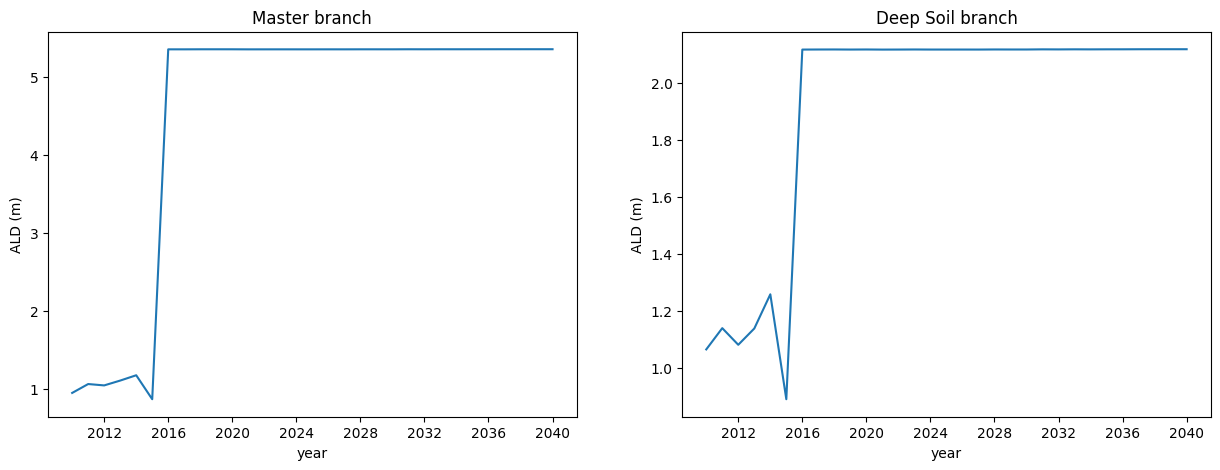

In [104]:
#PLOT ALD

# df_yearly, df_ds, df_yearly_m, df_m=plot_experiment('ALD','MD_deep_soil',0)

fig, ax = plt.subplots(1,2,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px')
df, meta = load_trsc_dataframe(var='ALD', timeres='yearly', px_y=1, px_x=1, fileprefix='output')
ax[0].plot(df.loc['2010':'2040'].index, df.loc['2010':'2040'][0], label='ALD')
ax[0].set_xlabel('year')
ax[0].set_ylabel('ALD ({})'.format(meta['var_units']))
ax[0].set_title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px')
df, meta = load_trsc_dataframe(var='ALD', timeres='yearly', px_y=1, px_x=1, fileprefix='output')
ax[1].plot(df.loc['2010':'2040'].index, df.loc['2010':'2040'][0], label='ALD')
ax[1].set_xlabel('year')
ax[1].set_ylabel('ALD ({})'.format(meta['var_units']))
ax[1].set_title('Deep Soil branch')

In [116]:
#master branch run
m_sp = xr.open_dataset('/data/workflows/MD_deep_soil/control_allout_monthly_11px/output/LAYERDEPTH_monthly_sp.nc')
m_tr = xr.open_dataset('/data/workflows/MD_deep_soil/control_allout_monthly_11px/output/LAYERDEPTH_monthly_tr.nc')
# m = xr.concat([m_sp, m_tr], dim="time")

#deep soil branch run
ds_sp = xr.open_dataset('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/output/ALD_yearly_sp.nc')
ds_tr = xr.open_dataset('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/output/ALD_yearly_tr.nc')
# ds = xr.concat([ds_sp, ds_tr], dim="time")

# m = m.to_dataframe()
# ds = ds.to_dataframe()

m_sp = m_sp.to_dataframe()
m_tr = m_tr.to_dataframe()

m_sp
# m_tr

IWCLAYER albers_conical_equal_area
time layer y x                                    
0    0     0 0       NaN                       b''
             1       NaN                       b''
             2       NaN                       b''
             3       NaN                       b''
             4       NaN                       b''
...                  ...                       ...
2999 21    9 5       NaN                       b''
             6       NaN                       b''
             7       NaN                       b''
             8       NaN                       b''
             9       NaN                       b''

[6600000 rows x 2 columns]

In [96]:
m_sp

<xarray.Dataset>
Dimensions:                    (time: 3000, layer: 22, y: 10, x: 10)
Dimensions without coordinates: time, layer, y, x
Data variables:
    TLAYER                     (time, layer, y, x) float64 ...
    albers_conical_equal_area  |S1 ...
Attributes:
    Git_SHA:

In [97]:
m_tr

<xarray.Dataset>
Dimensions:                    (time: 1380, layer: 22, y: 10, x: 10)
Coordinates:
  * time                       (time) object 1901-01-01 00:00:00 ... 2015-12-...
Dimensions without coordinates: layer, y, x
Data variables:
    TLAYER                     (time, layer, y, x) float64 ...
    albers_conical_equal_area  |S1 ...
Attributes:
    Git_SHA:

In [139]:
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='LAYERDEPTH', timeres='monthly', px_y=1, px_x=1, fileprefix='output')

Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc


In [140]:
df

0     1     2         3         4         5         6         7   \
1901-01-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
1901-02-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
1901-03-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
1901-04-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
1901-05-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
...         ...   ...   ...       ...       ...       ...       ...       ...   
2100-08-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   
2100-09-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   
2100-10-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   
2100-11-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   
2100-12-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   

                  8         9   ...        12        13        14        15  \
1901-01-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
1901-02-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
1901-03-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
1901-04-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
1901-05-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
...              ...       ...  ...       ...       ...       ...       ...   
2100-08-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   
2100-09-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   
2100-10-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   
2100-11-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   
2100-12-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   

                  16        17        18        19      20      21  
1901-01-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
1901-02-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
1901-03-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
1901-04-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
1901-05-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
...              ...       ...       ...       ...     ...     ...  
2100-08-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  
2100-09-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  
2100-10-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  
2100-11-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  
2100-12-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  

[2400 rows x 22 columns]

## temperature in mineral layers ("bottom")

Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc


Text(0.5, 1.0, 'MD_deep_soil Pixel 1,1, cmt:1, yearly averages')

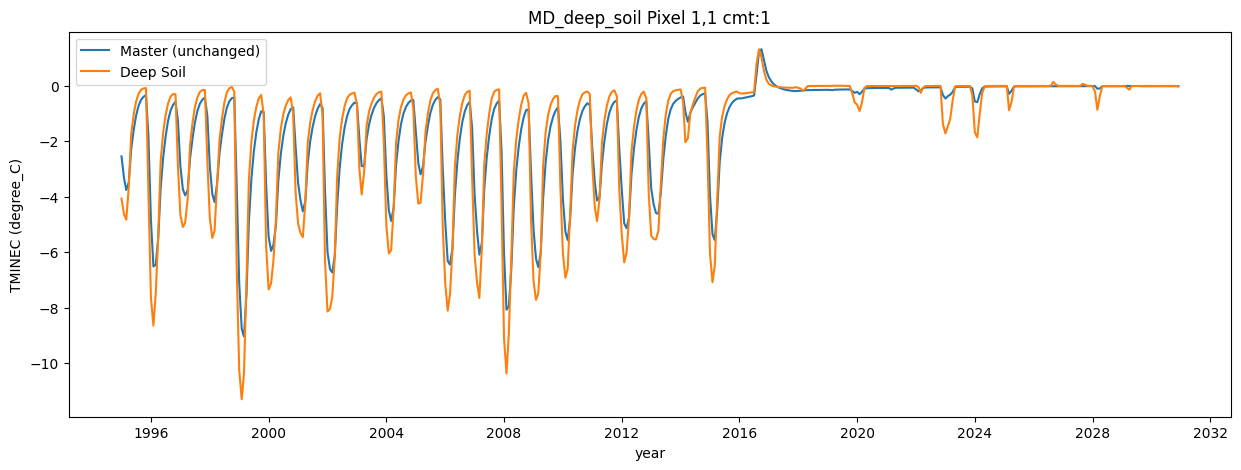

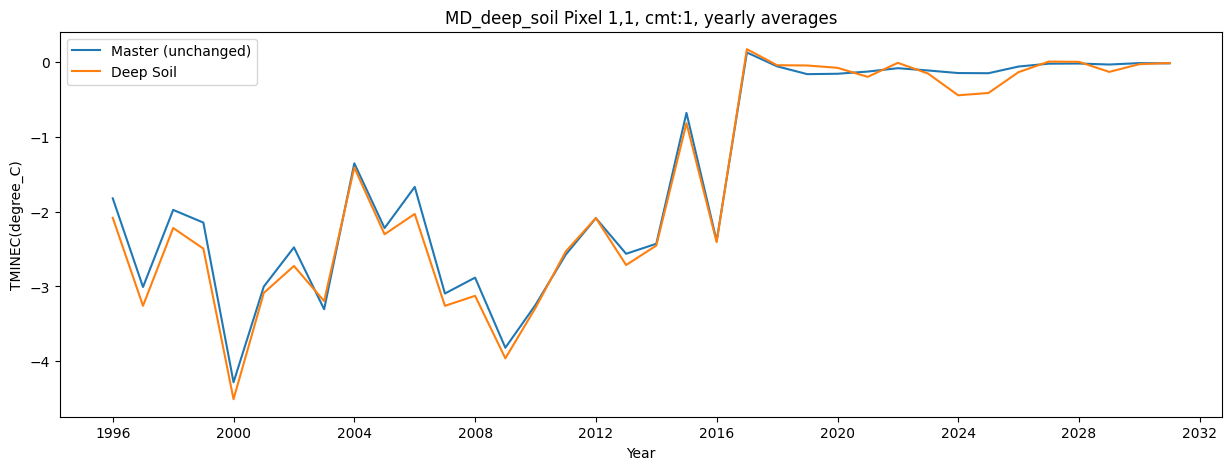

In [43]:
#PLOT TMINE, without finding yearly average
# TMINEA,Temperature top mineral,degree_C,y,m,,invalid,invalid,invalid,double,
# TMINEB,Temperature middle mineral,degree_C,y,m,,invalid,invalid,invalid,double,
# TMINEC,Temperature bottom mineral,degree_C,y,m,,invalid,invalid,invalid,double,

fig, ax = plt.subplots(1,1,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df.loc['1995':'2030'].index, df.loc['1995':'2030'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('TMINEC ({})'.format(meta['var_units']))
# plt.title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df_ds, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df_ds.loc['1995':'2030'].index, df_ds.loc['1995':'2030'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('TMINEC ({})'.format(meta['var_units']))
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1 cmt:1')

#TMINEC, yearly average
folder='MD_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='TMINEC'
layer=7
year='1995'
end_year='2030'
time = 'monthly'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

plot_data(folder, run_folder_control, time, output_var, px_y, px_x, layer, year, end_year)
plot_data(folder, run_folder_experiment, time, output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1, cmt:1, yearly averages')

## IWC

Ice water content by layer

Trying to open:  output/IWCLAYER_monthly_tr.nc
Trying to open:  output/IWCLAYER_monthly_sc.nc
Trying to open:  output/IWCLAYER_monthly_tr.nc
Trying to open:  output/IWCLAYER_monthly_sc.nc
Trying to open:  output/IWCLAYER_monthly_tr.nc
Trying to open:  output/IWCLAYER_monthly_sc.nc
Trying to open:  output/IWCLAYER_monthly_tr.nc
Trying to open:  output/IWCLAYER_monthly_sc.nc


Text(0.5, 1.0, 'MD_deep_soil Pixel 1,1, cmt:1, yearly averages')

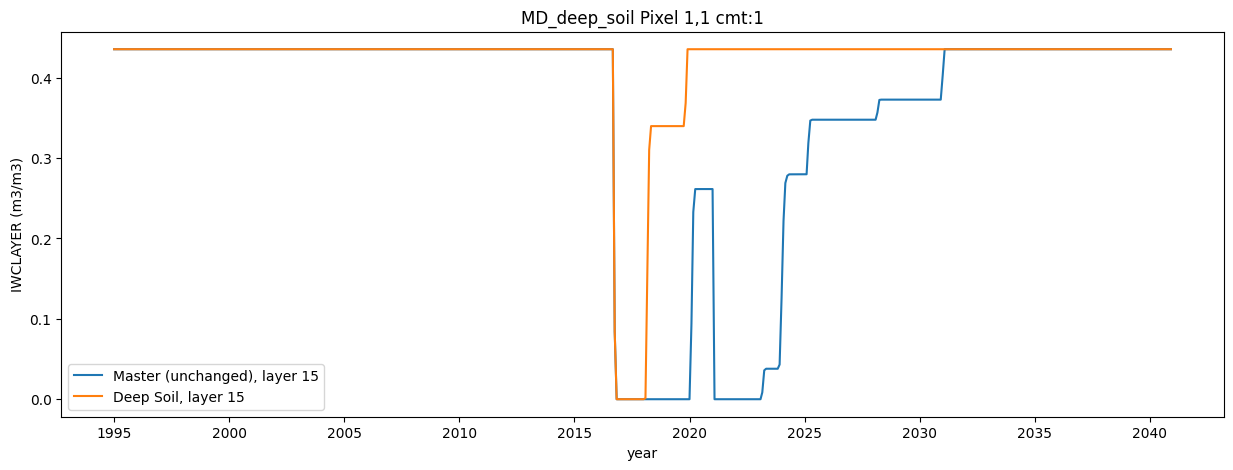

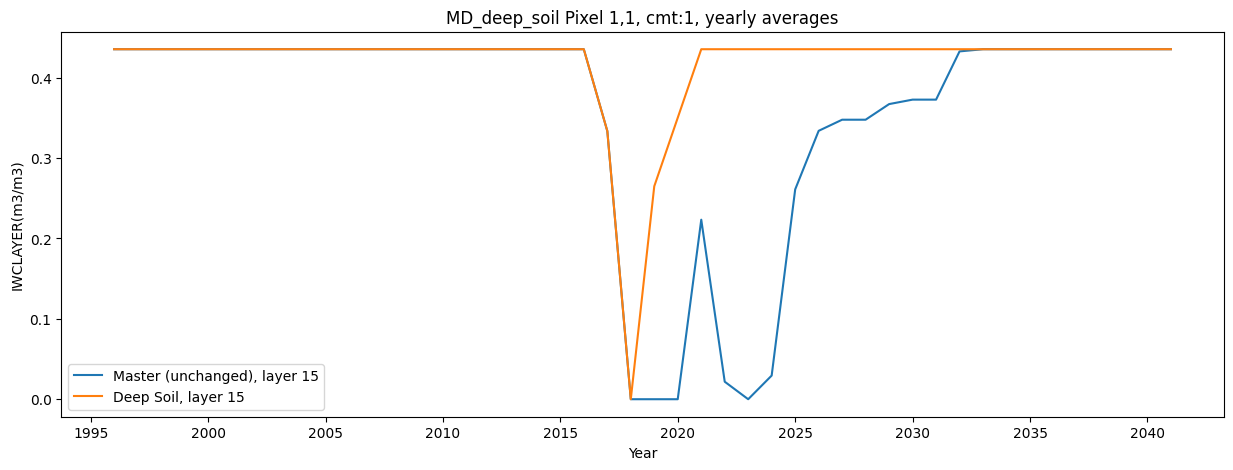

In [146]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='IWCLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df.loc['1995':'2040'].index, df.loc['1995':'2040'][15], label='IWCLAYER')
plt.xlabel('year')
plt.ylabel('IWCLAYER ({})'.format(meta['var_units']))
# plt.title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df_ds, meta = load_trsc_dataframe(var='IWCLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df_ds.loc['1995':'2040'].index, df_ds.loc['1995':'2040'][15], label='IWCLAYER')
plt.xlabel('year')
plt.ylabel('IWCLAYER ({})'.format(meta['var_units']))
ax.legend(['Master (unchanged), layer 15', 'Deep Soil, layer 15'])
plt.title(folder+' Pixel 1,1 cmt:1')

#IWC, yearly average
folder='MD_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='IWCLAYER'
layer=15
year='1995'
end_year='2040'
time = 'monthly'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

plot_data(folder, run_folder_control, time, output_var, px_y, px_x, layer, year, end_year)
plot_data(folder, run_folder_experiment, time, output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged), layer 15', 'Deep Soil, layer 15'])
plt.title(folder+' Pixel 1,1, cmt:1, yearly averages')

## LWC

yearly averages show jump around 2015/2016, after ALD jumps

Trying to open:  output/LWCLAYER_monthly_tr.nc
Trying to open:  output/LWCLAYER_monthly_sc.nc
Trying to open:  output/LWCLAYER_monthly_tr.nc
Trying to open:  output/LWCLAYER_monthly_sc.nc
Trying to open:  output/LWCLAYER_monthly_tr.nc
Trying to open:  output/LWCLAYER_monthly_sc.nc
Trying to open:  output/LWCLAYER_monthly_tr.nc
Trying to open:  output/LWCLAYER_monthly_sc.nc


Text(0.5, 1.0, 'MD Pixel 1,1, cmt:1, yearly averages')

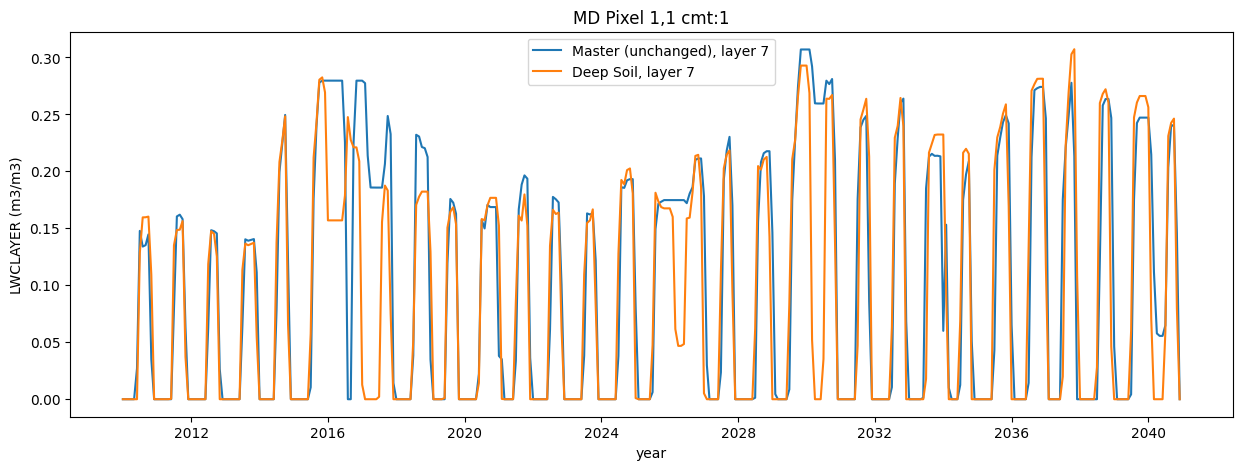

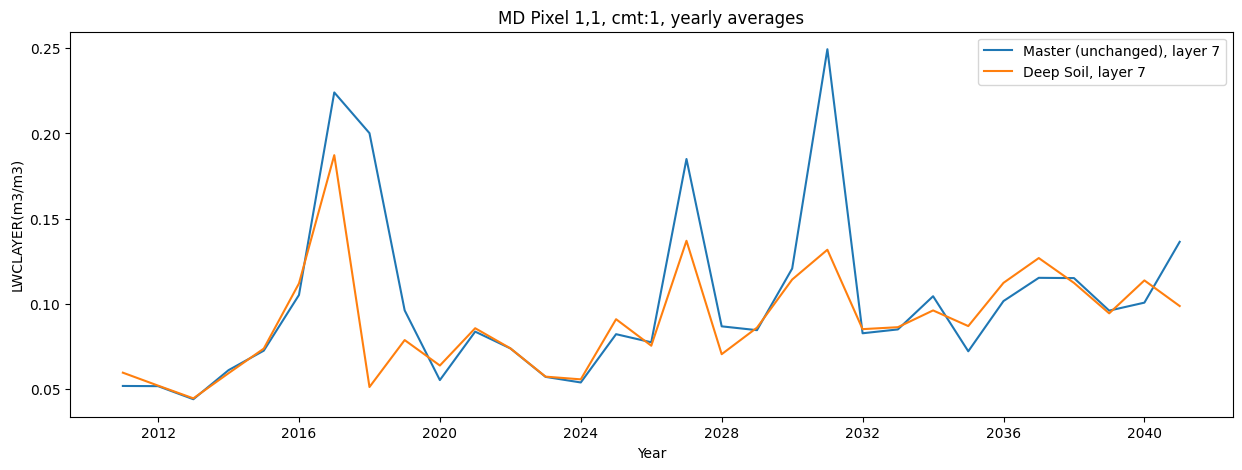

In [139]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='LWCLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df.loc['2010':'2040'].index, df.loc['2010':'2040'][7], label='LWCLAYER')
plt.xlabel('year')
plt.ylabel('LWCLAYER ({})'.format(meta['var_units']))
# plt.title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df_ds, meta = load_trsc_dataframe(var='LWCLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df_ds.loc['2010':'2040'].index, df_ds.loc['2010':'2040'][7], label='LWCLAYER')
plt.xlabel('year')
plt.ylabel('LWCLAYER ({})'.format(meta['var_units']))
ax.legend(['Master (unchanged), layer 7', 'Deep Soil, layer 7'])
plt.title('MD Pixel 1,1 cmt:1')

#IWC, yearly average
folder='MD_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='LWCLAYER'
layer=7
year='2010'
end_year='2040'
time = 'monthly'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

plot_data(folder, run_folder_control, time, output_var, px_y, px_x, 7, year, end_year)
plot_data(folder, run_folder_experiment, time, output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged), layer 7', 'Deep Soil, layer '+str(layer)])
plt.title('MD Pixel 1,1, cmt:1, yearly averages')

In [69]:
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px')
df, meta = load_trsc_dataframe(var='LAYERDEPTH', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df

Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc


0     1     2         3         4         5         6         7   \
1901-01-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
1901-02-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
1901-03-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
1901-04-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
1901-05-01  0.0  0.01  0.03  0.050090  0.082936  0.148628  0.248628  0.348628   
...         ...   ...   ...       ...       ...       ...       ...       ...   
2100-08-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   
2100-09-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   
2100-10-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   
2100-11-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   
2100-12-01  0.0  0.01  0.03  0.050947  0.088008  0.162130  0.262130  0.362130   

                  8         9   ...        12        13        14        15  \
1901-01-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
1901-02-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
1901-03-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
1901-04-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
1901-05-01  0.448628  0.548628  ...  1.148628  1.448628  1.748628  2.048628   
...              ...       ...  ...       ...       ...       ...       ...   
2100-08-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   
2100-09-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   
2100-10-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   
2100-11-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   
2100-12-01  0.462130  0.562130  ...  1.162130  1.462130  1.762130  2.062130   

                  16        17        18        19      20      21  
1901-01-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
1901-02-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
1901-03-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
1901-04-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
1901-05-01  2.348628  2.848628  3.348628  4.348628 -9999.0 -9999.0  
...              ...       ...       ...       ...     ...     ...  
2100-08-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  
2100-09-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  
2100-10-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  
2100-11-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  
2100-12-01  2.362130  2.862130  3.362130  4.362130 -9999.0 -9999.0  

[2400 rows x 22 columns]

Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc


Text(0.5, 1.0, ' BNZ Pixel 1,1 cmt:1')

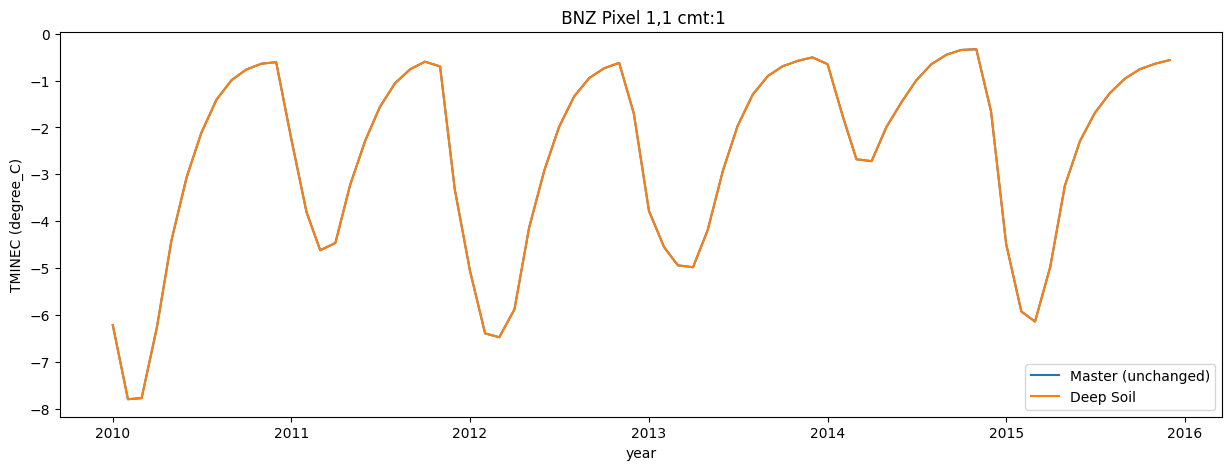

In [3]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/BNZ_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df.loc['2010':'2015'].index, df.loc['2010':'2015'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('TMINEC ({})'.format(meta['var_units']))
# plt.title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/BNZ_deep_soil/experiment_allout_monthly_11px/')
df_ds, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df_ds.loc['2010':'2015'].index, df_ds.loc['2010':'2015'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('TMINEC ({})'.format(meta['var_units']))
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(' BNZ Pixel 1,1 cmt:1')

Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc


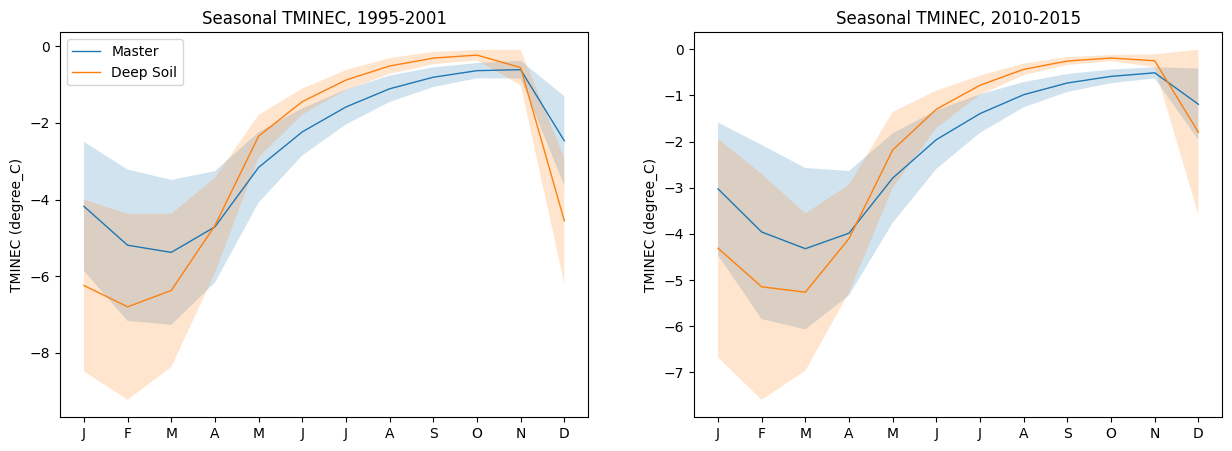

In [10]:
#SEASONAL Temp and thermal conductivity, minec 
#MURPHY DOME

fig, ax = plt.subplots(1,2,figsize=(15, 5))

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
n=0
for time_period in ['1995-2001','2010-2015']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[n].plot(mean, linewidth=1, label=time_period)
  ax[n].fill_between(mean.index, mean - std, mean + std, alpha=0.2, label='_nolegend_')
  ax[n].set_ylabel('TMINEC ({})'.format(meta['var_units']))
#   ax[1].legend()
  n=n+1
ax[1].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[1].set_title('Seasonal TMINEC, 2010-2015')

os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
n=0
for time_period in ['1995-2001','2010-2015']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[n].plot(mean, linewidth=1, label=time_period)
  ax[n].fill_between(mean.index, mean - std, mean + std, alpha=0.2, label='_nolegend_')
  ax[n].set_ylabel('TMINEC ({})'.format(meta['var_units']))
#   ax[n].legend()
  n=n+1
ax[0].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[0].set_title('Seasonal TMINEC, 1995-2001')

ax[0].legend(['Master','Deep Soil'])


Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc


Text(0.5, 1.0, 'Seasonal TMINEC, Deep Soil Branch')

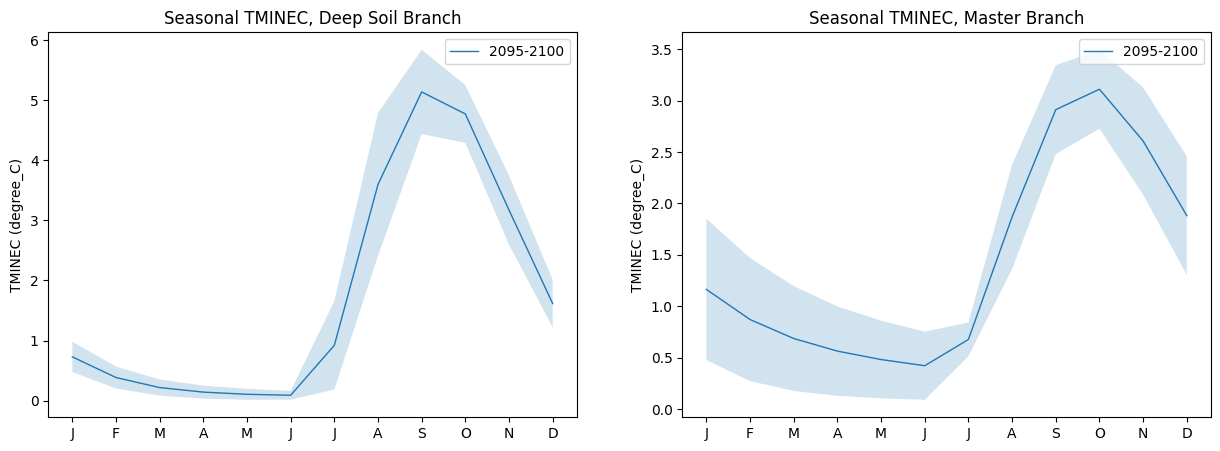

In [11]:
#SEASONAL Temp and thermal conductivity, minec

fig, ax = plt.subplots(1,2,figsize=(15, 5))

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
for time_period in ['2095-2100']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[1].plot(mean, linewidth=1, label=time_period)
  ax[1].fill_between(mean.index, mean - std, mean + std, alpha=0.2)
  ax[1].set_ylabel('TMINEC ({})'.format(meta['var_units']))
  ax[1].legend()
ax[1].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[1].set_title('Seasonal TMINEC, Master Branch')

os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
for time_period in ['2095-2100']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[0].plot(mean, linewidth=1, label=time_period)
  ax[0].fill_between(mean.index, mean - std, mean + std, alpha=0.2)
  ax[0].set_ylabel('TMINEC ({})'.format(meta['var_units']))
  ax[0].legend()
ax[0].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[0].set_title('Seasonal TMINEC, Deep Soil Branch')

Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc


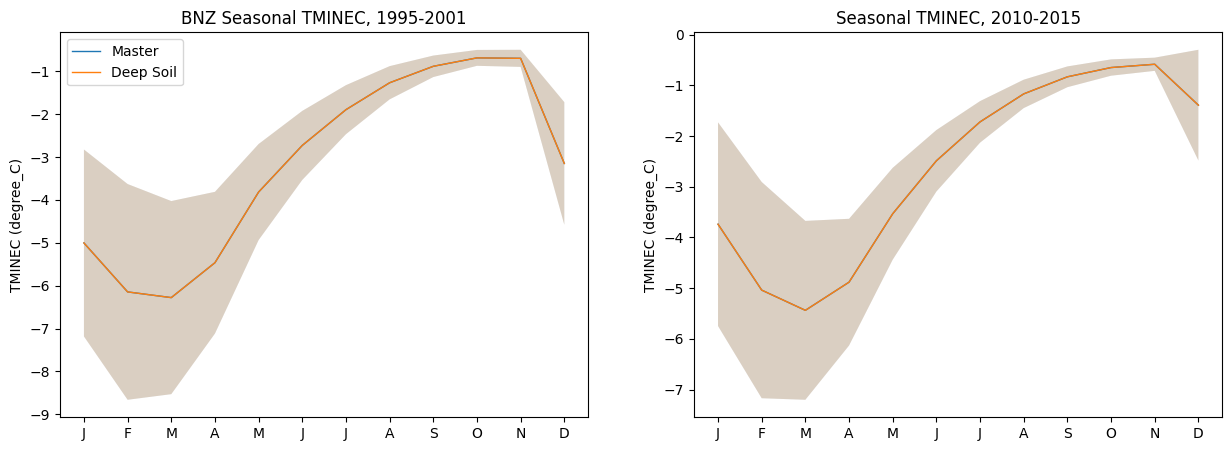

In [12]:
#SEASONAL Temp and thermal conductivity, minec 
#BNZ
fig, ax = plt.subplots(1,2,figsize=(15, 5))

os.chdir('/data/workflows/BNZ_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
n=0
for time_period in ['1995-2001','2010-2015']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[n].plot(mean, linewidth=1, label=time_period)
  ax[n].fill_between(mean.index, mean - std, mean + std, alpha=0.2, label='_nolegend_')
  ax[n].set_ylabel('TMINEC ({})'.format(meta['var_units']))
#   ax[1].legend()
  n=n+1
ax[1].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[1].set_title('Seasonal TMINEC, 2010-2015')

os.chdir('/data/workflows/BNZ_deep_soil/experiment_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
n=0
for time_period in ['1995-2001','2010-2015']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[n].plot(mean, linewidth=1, label=time_period)
  ax[n].fill_between(mean.index, mean - std, mean + std, alpha=0.2, label='_nolegend_')
  ax[n].set_ylabel('TMINEC ({})'.format(meta['var_units']))
#   ax[n].legend()
  n=n+1
ax[0].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[0].set_title('BNZ Seasonal TMINEC, 1995-2001')

ax[0].legend(['Master', 'Deep Soil'])


## GPP, DEEPC, DEEPDZ

Trying to open:  output/GPP_yearly_tr.nc
Trying to open:  output/GPP_yearly_sc.nc
Trying to open:  output/GPP_yearly_tr.nc
Trying to open:  output/GPP_yearly_sc.nc


Text(0.5, 1.0, 'MD_deep_soil Pixel 1,1, cmt:1')

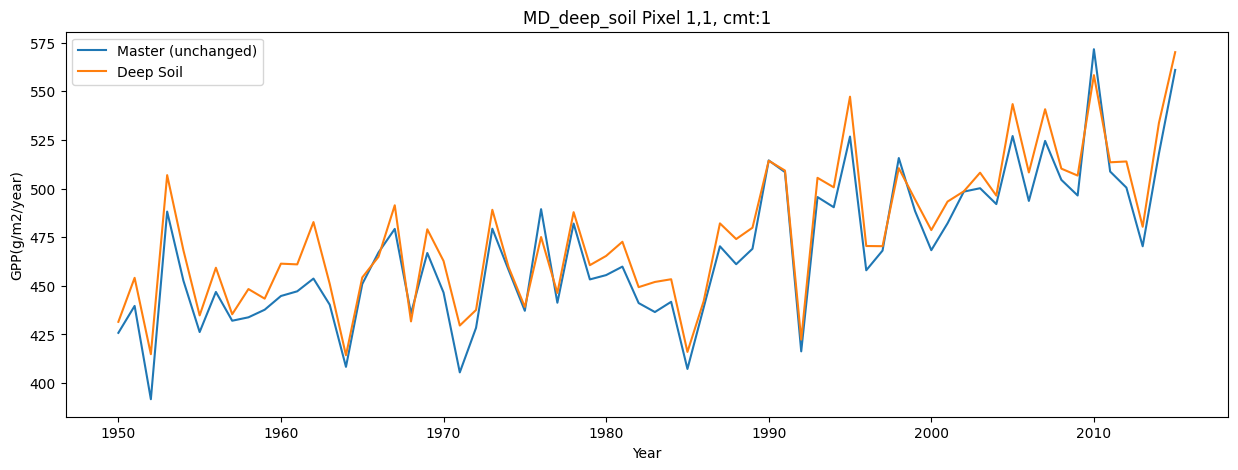

In [2]:
folder='MD_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='GPP'
layer=7
year='1950'
end_year='2015'
time = 'yearly'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, time, output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, time, output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1, cmt:1')

Trying to open:  output/GPP_yearly_tr.nc
Trying to open:  output/GPP_yearly_sc.nc
Trying to open:  output/GPP_yearly_tr.nc
Trying to open:  output/GPP_yearly_sc.nc


Text(0.5, 1.0, 'BNZ_deep_soil Pixel 1,1, cmt:1')

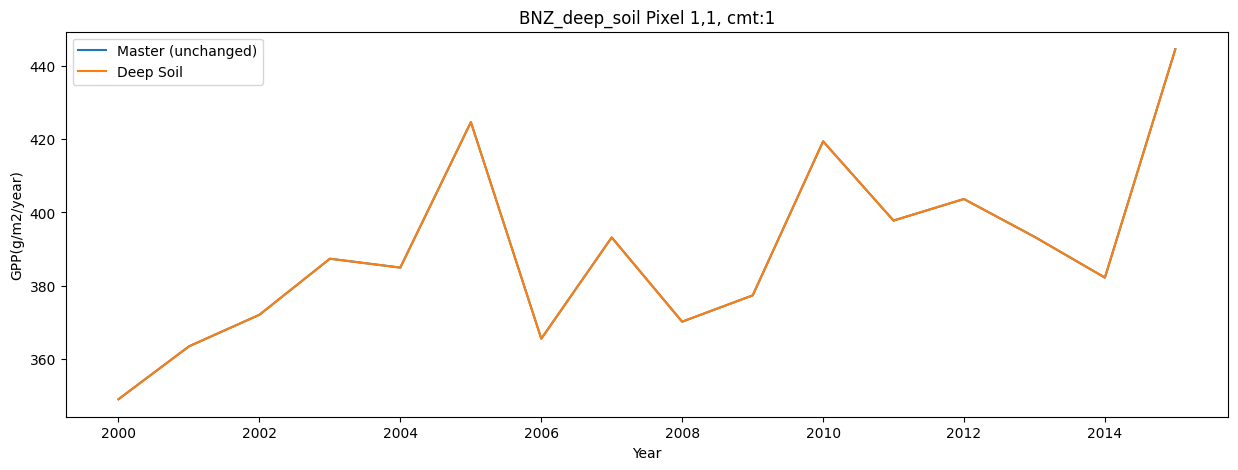

In [3]:
folder='BNZ_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='GPP'
layer=7
year='2000'
end_year='2015'
time = 'yearly'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, time, output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, time, output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1, cmt:1')

Trying to open:  output/DEEPC_monthly_tr.nc
Trying to open:  output/DEEPC_monthly_sc.nc
Trying to open:  output/DEEPC_monthly_tr.nc
Trying to open:  output/DEEPC_monthly_sc.nc


Text(0.5, 1.0, 'MD_deep_soil Pixel 1,1, cmt:1')

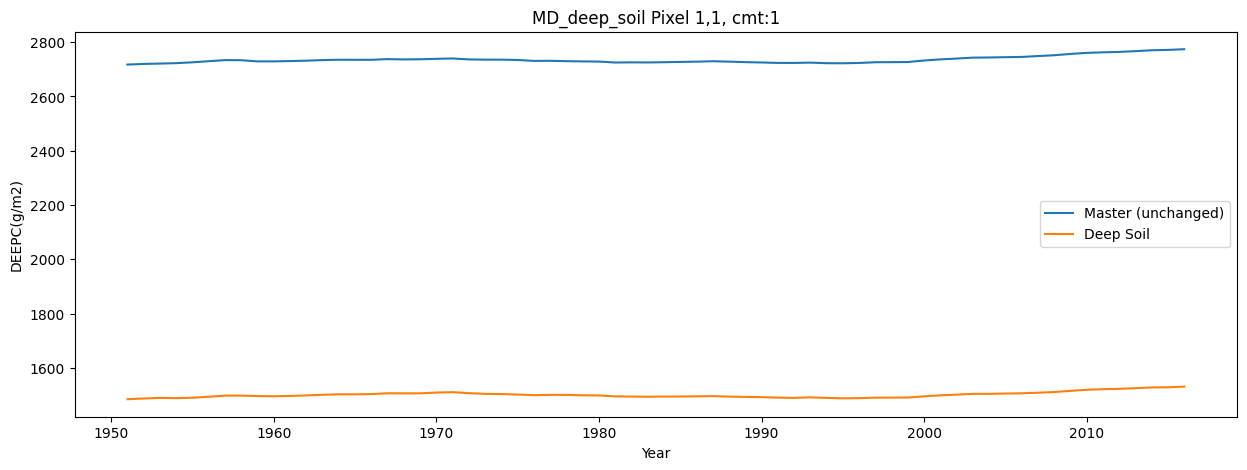

In [4]:
#DEEPC,Amorphous SOM C,g/m2,y,m,invalid,invalid,invalid,invalid,double,
#DEEPDZ,Amorphous SOM horizon thickness,m,y,invalid,invalid,invalid,invalid,invalid,double,
#soil organic matter (SOM)
folder='MD_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='DEEPC'
layer=7
year='1950'
end_year='2015'
time = 'monthly'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, time, output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, time, output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1, cmt:1')

Trying to open:  output/DEEPC_monthly_tr.nc
Trying to open:  output/DEEPC_monthly_sc.nc
Trying to open:  output/DEEPC_monthly_tr.nc
Trying to open:  output/DEEPC_monthly_sc.nc


Text(0.5, 1.0, 'BNZ_deep_soil Pixel 1,1, cmt:1')

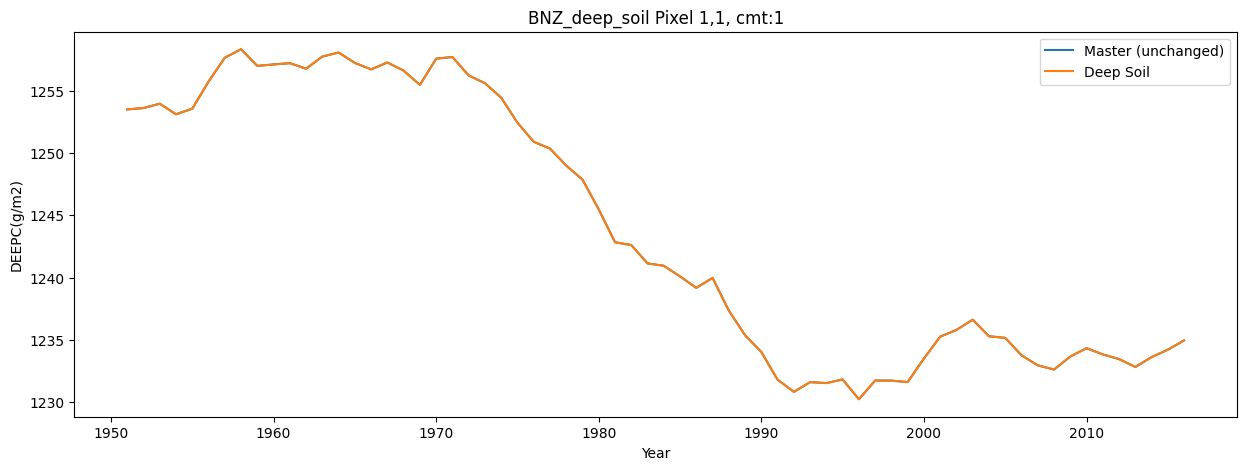

In [5]:
#DEEPC,Amorphous SOM C,g/m2,y,m,invalid,invalid,invalid,invalid,double,
#DEEPDZ,Amorphous SOM horizon thickness,m,y,invalid,invalid,invalid,invalid,invalid,double,
#soil organic matter (SOM)
folder='BNZ_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='DEEPC'
layer=7
year='1950'
end_year='2015'
time = 'monthly'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, time, output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, time, output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1, cmt:1')

## Compare to observations

In [28]:
data_path='/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
os.chdir(data_path)
df, meta = load_trsc_dataframe(var='TLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_depth, meta_depth = load_trsc_dataframe(var='LAYERDEPTH', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_dz, meta_dzh = load_trsc_dataframe(var='LAYERDZ', timeres='monthly', px_y=1, px_x=1, fileprefix='output')

# Assuming you have imported the dataframes `df` and `df_depth`

# Convert index of `df` to datetime
df.index = pd.to_datetime(df.index)

# Extract necessary data
depths = df_depth.iloc[:,:-2].values
dz = df_dz.iloc[:,:-2].values
times = df.index
temperature = df.iloc[:,:-2].values
xp = (depths + dz/2) #center of each layer,  x-coordinates of the data points for np.interp

# Create a regular grid of depth values
# regular_depths = np.linspace(depths.min(), depths.max(), num=500)  # Adjust the `num` parameter as desired
regular_depths = np.arange(0, depths.max(), 0.1)

# Create meshgrid for depth and time
depth_mesh, time_mesh = np.meshgrid(regular_depths, times)

# Interpolate temperature onto the regular grid
interp_temperature = np.empty_like(depth_mesh)
for i, t in enumerate(times):
    interp_temperature[i, :] = np.interp(regular_depths, xp[i, :], temperature[i, :])

Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc


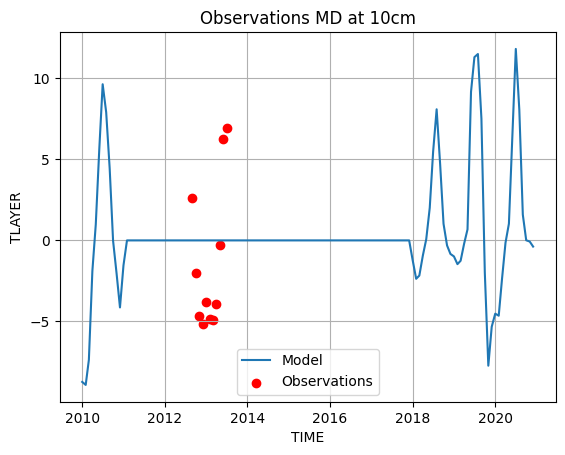

In [29]:
# Desired depth for plotting
desired_depth = 0.1

# Find the index corresponding to the desired_depth in the regular_depths array
depth_index = np.where(regular_depths == desired_depth)[0][0]

# Extract the interpolated temperature time series for the desired depth
temperature_time_series = interp_temperature[:, depth_index]

# Define the start and end dates of the time range you want to plot
start_date = '2010-01-01'
end_date = '2020-12-31'
# Convert index of `times` to datetime
times = pd.to_datetime(times)

# Check if the specified time range is within the available range
if (times.min() <= pd.to_datetime(start_date)) and (pd.to_datetime(end_date) <= times.max()):
    # Filter the data within the specified time range
    mask = (times >= start_date) & (times <= end_date)
    filtered_times = times[mask]
    filtered_temperature_time_series = temperature_time_series[mask]

# Plot the time series at the selected depth for the specified time range
plt.plot(filtered_times, filtered_temperature_time_series)
# Plot the time series at the selected depth
# plt.plot(times, temperature_time_series)
plt.xlabel('Time')
plt.ylabel('Interpolated Temperature')
plt.title(f'Time Series at Depth: {desired_depth}m')
plt.grid(True)
# plt.show()

obs_df = pd.read_csv("/work/deep_soil_runs/Obs/Melvinetal_TLAYER_10cm.csv")
times = obs_df.loc[:, 'time']
times = pd.to_datetime(times)

plt.scatter(times,obs_df['TLAYER'], c='red')
plt.xlabel('TIME')
plt.ylabel('TLAYER')
plt.title('Observations MD at 10cm')
plt.legend(['Model','Observations'])
plt.show()


Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc


/tmp/ipykernel_81/3170173049.py:27: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  df_at_depth = df.lookup(df.loc[year:end_year].index, depth_index.loc[year:end_year])
/tmp/ipykernel_81/3170173049.py:28: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  df_master_at_depth = df_master.lookup(df_master.loc[year:end_year].index, depth_index_master.loc[year:end_year])
/tmp/ipykernel_81/3170173049.py:29: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  df_n_at_depth = df_n.lookup(df_n.loc[year:end_year].index, depth_index_n.loc[year:end_year])


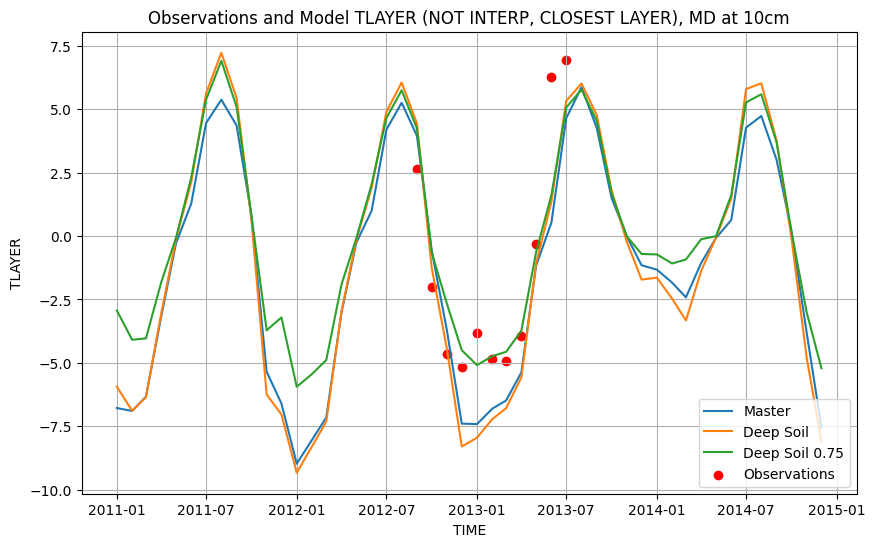

In [6]:
data_path='/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
os.chdir(data_path)
df_master, meta_master = load_trsc_dataframe(var='TLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_depth_master, meta_depth = load_trsc_dataframe(var='LAYERDEPTH', timeres='monthly', px_y=1, px_x=1, fileprefix='output')

data_path='/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/'
os.chdir(data_path)
df, meta = load_trsc_dataframe(var='TLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_depth, meta_depth = load_trsc_dataframe(var='LAYERDEPTH', timeres='monthly', px_y=1, px_x=1, fileprefix='output')

data_path='/data/workflows/MD_deep_soil/nfactorw0.75_monthly_11px/'
os.chdir(data_path)
df_n, meta_n = load_trsc_dataframe(var='TLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_depth_n, meta_depth_n = load_trsc_dataframe(var='LAYERDEPTH', timeres='monthly', px_y=1, px_x=1, fileprefix='output')

year='2011'
end_year='2014'

# Find the index of the layer closest to 0.1m in df_depth dataframe
desired_depth = 0.1
depth_index = abs(df_depth - desired_depth).idxmin(axis=1)
depth_index_master = abs(df_depth_master - desired_depth).idxmin(axis=1)
depth_index_n = abs(df_depth_n - desired_depth).idxmin(axis=1)


# Extract the data at the desired depth and timeframe from df and df_master dataframes
df_at_depth = df.lookup(df.loc[year:end_year].index, depth_index.loc[year:end_year])
df_master_at_depth = df_master.lookup(df_master.loc[year:end_year].index, depth_index_master.loc[year:end_year])
df_n_at_depth = df_n.lookup(df_n.loc[year:end_year].index, depth_index_n.loc[year:end_year])


# Plot the time series for df and df_master at the desired depth
plt.figure(figsize=(10, 6))
plt.plot(df_master.loc[year:end_year].index, df_master_at_depth, label='Master Data')
plt.plot(df.loc[year:end_year].index, df_at_depth, label='Experiment Data')
plt.plot(df_n.loc[year:end_year].index, df_n_at_depth, label='nfactor Data')
plt.xlabel('Time')
# plt.ylabel('TLAYER at 0.1m Depth')
# plt.title('Time Series at 0.1m Depth')
plt.legend()
plt.grid(True)


obs_df = pd.read_csv("/work/deep_soil_runs/Obs/Melvinetal_TLAYER_10cm.csv")
times = obs_df.loc[:, 'time']
times = pd.to_datetime(times)

plt.scatter(times,obs_df['TLAYER'], c='red')
plt.xlabel('TIME')
plt.ylabel('TLAYER')
plt.title('Observations and Model TLAYER (NOT INTERP, CLOSEST LAYER), MD at 10cm')
plt.legend(['Master','Deep Soil','Deep Soil 0.75','Observations'])
plt.show()


In [36]:
from scipy.interpolate import interp1d

def interp_by_depth(df, df_depth, df_dz, desired_depth, start_date, end_date):

    # Convert index of `df` to datetime
    df.index = pd.to_datetime(df.index)

    # Extract necessary data
    depths = df_depth.iloc[:, :-2].values
    dz = df_dz.iloc[:, :-2].values
    times = df.index
    temperature = df.iloc[:, :-2].values
    xp = (depths + dz / 2)  # Center of each layer, x-coordinates of the data points for interp1d

    # Create a regular grid of depth values
    regular_depths = np.arange(0, depths.max(), 0.1)

    # Interpolate temperature onto the regular grid
    interp_temperature = np.empty((temperature.shape[0], regular_depths.shape[0]))
    for i in range(temperature.shape[0]):
        f = interp1d(xp[i], temperature[i], kind='linear', fill_value='extrapolate')
        interp_temperature[i] = f(regular_depths)

    # Desired depth for plotting
    desired_depth = 0.1

    # Find the index corresponding to the desired_depth in the regular_depths array
    depth_index = np.where(regular_depths == desired_depth)[0][0]

    # Extract the interpolated temperature time series for the desired depth
    temperature_time_series = interp_temperature[:, depth_index]

    # Convert index of `times` to datetime
    times = pd.to_datetime(times)

    # Check if the specified time range is within the available range
    if (times.min() <= pd.to_datetime(start_date)) and (pd.to_datetime(end_date) <= times.max()):
        # Filter the data within the specified time range
        mask = (times >= start_date) & (times <= end_date)
        filtered_times = times[mask]
        filtered_temperature_time_series = temperature_time_series[mask]
    return filtered_temperature_time_series, filtered_times

Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc


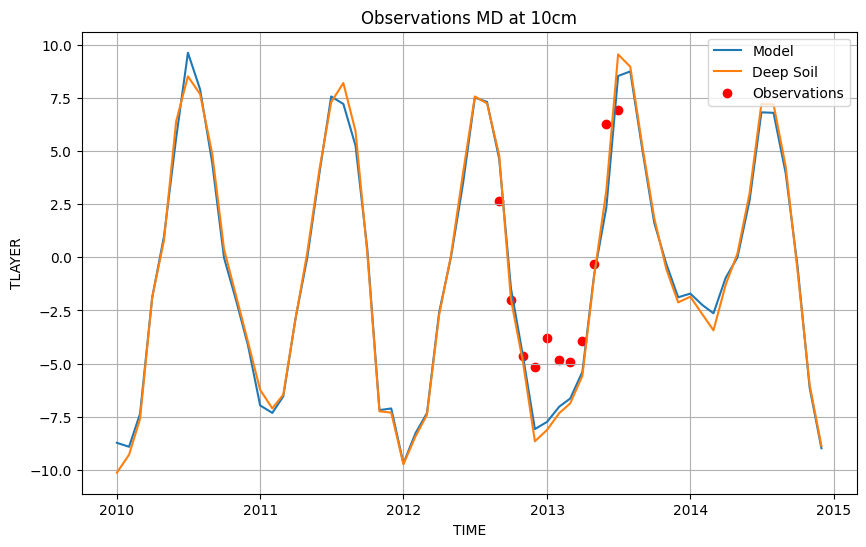

In [37]:
start_date = '2010-01-01'
end_date = '2014-12-31'
desired_depth - 0.1

data_path = '/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
os.chdir(data_path)
df_m, meta_m = load_trsc_dataframe(var='TLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_depth_m, meta_depth_m = load_trsc_dataframe(var='LAYERDEPTH', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_dz_m, meta_dzh_m = load_trsc_dataframe(var='LAYERDZ', timeres='monthly', px_y=1, px_x=1, fileprefix='output')

time_series_m, time_m = interp_by_depth(df_m, df_depth_m, df_dz_m, desired_depth, start_date, end_date)

data_path = '/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/'
os.chdir(data_path)
df, meta = load_trsc_dataframe(var='TLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_depth, meta_depth = load_trsc_dataframe(var='LAYERDEPTH', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_dz, meta_dzh = load_trsc_dataframe(var='LAYERDZ', timeres='monthly', px_y=1, px_x=1, fileprefix='output')

time_series, time = interp_by_depth(df, df_depth, df_dz, desired_depth, start_date, end_date)

# Plot the time series at the selected depth for the specified time range
plt.figure(figsize=(10, 6))
plt.plot(time_m, time_series_m)
plt.plot(time, time_series)
plt.xlabel('Time')
plt.ylabel('Interpolated Temperature')
plt.title(f'Time Series at Depth: {desired_depth}m')
plt.grid(True)

obs_df = pd.read_csv("/work/deep_soil_runs/Obs/Melvinetal_TLAYER_10cm.csv")
times = obs_df.loc[:, 'time']
times = pd.to_datetime(times)

plt.scatter(times, obs_df['TLAYER'], c='red')
plt.xlabel('TIME')
plt.ylabel('TLAYER')
plt.title('Observations MD at 10cm')
plt.legend(['Model', 'Deep Soil', 'Observations'])
plt.show()


## Soil temp contour plot

See Elchin's paper for example:
https://iopscience.iop.org/article/10.1088/1748-9326/8/3/035030/pdf
Should I plot more defined contours like in the paper, or leave as the below??

For Talik, it looks like when zooming into 2060-2100, around a 30m depth gives pockets of areas just over freezing. Is that actually talik though? not much higher than freezing, and location jumps

In [32]:
df_dz

0         1         2        3         4    5    6    7    8   \
1901-01-01  0.01  0.039841  0.066572  0.10000  0.100000  0.1  0.1  0.1  0.1   
1901-02-01  0.01  0.039841  0.066572  0.10000  0.100000  0.1  0.1  0.1  0.1   
1901-03-01  0.01  0.039841  0.066572  0.10000  0.100000  0.1  0.1  0.1  0.1   
1901-04-01  0.01  0.039841  0.066572  0.10000  0.100000  0.1  0.1  0.1  0.1   
1901-05-01  0.01  0.039841  0.066572  0.10000  0.100000  0.1  0.1  0.1  0.1   
...          ...       ...       ...      ...       ...  ...  ...  ...  ...   
2100-08-01  0.01  0.020000  0.020204  0.02602  0.052041  0.1  0.1  0.1  0.1   
2100-09-01  0.01  0.020000  0.020204  0.02602  0.052041  0.1  0.1  0.1  0.1   
2100-10-01  0.01  0.020000  0.020204  0.02602  0.052041  0.1  0.1  0.1  0.1   
2100-11-01  0.01  0.020000  0.020204  0.02602  0.052041  0.1  0.1  0.1  0.1   
2100-12-01  0.01  0.020000  0.020204  0.02602  0.052041  0.1  0.1  0.1  0.1   

             9   ...   43   44   45   46   47   48      49      50      51  \
1901-01-01  0.1  ...  3.0  3.0  5.0  5.0  5.0  5.0 -9999.0 -9999.0 -9999.0   
1901-02-01  0.1  ...  3.0  3.0  5.0  5.0  5.0  5.0 -9999.0 -9999.0 -9999.0   
1901-03-01  0.1  ...  3.0  3.0  5.0  5.0  5.0  5.0 -9999.0 -9999.0 -9999.0   
1901-04-01  0.1  ...  3.0  3.0  5.0  5.0  5.0  5.0 -9999.0 -9999.0 -9999.0   
1901-05-01  0.1  ...  3.0  3.0  5.0  5.0  5.0  5.0 -9999.0 -9999.0 -9999.0   
...         ...  ...  ...  ...  ...  ...  ...  ...     ...     ...     ...   
2100-08-01  0.1  ...  2.0  3.0  3.0  3.0  5.0  5.0     5.0     5.0 -9999.0   
2100-09-01  0.1  ...  2.0  3.0  3.0  3.0  5.0  5.0     5.0     5.0 -9999.0   
2100-10-01  0.1  ...  2.0  3.0  3.0  3.0  5.0  5.0     5.0     5.0 -9999.0   
2100-11-01  0.1  ...  2.0  3.0  3.0  3.0  5.0  5.0     5.0     5.0 -9999.0   
2100-12-01  0.1  ...  2.0  3.0  3.0  3.0  5.0  5.0     5.0     5.0 -9999.0   

                52  
1901-01-01 -9999.0  
1901-02-01 -9999.0  
1901-03-01 -9999.0  
1901-04-01 -9999.0  
1901-05-01 -9999.0  
...            ...  
2100-08-01 -9999.0  
2100-09-01 -9999.0  
2100-10-01 -9999.0  
2100-11-01 -9999.0  
2100-12-01 -9999.0  

[2400 rows x 53 columns]

In [35]:
os.chdir(data_path)
df, meta = load_trsc_dataframe(var='TLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output') 
df_depth, meta_depth = load_trsc_dataframe(var='LAYERDEPTH',  timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_dz, meta_dzh = load_trsc_dataframe(var='LAYERDZ',  timeres='monthly', px_y=1, px_x=1, fileprefix='output')

layers = df.columns.astype(float)
times = pd.to_datetime(df.index)

# # Filter data based on start_time and end_time
# if start_time is not None and end_time is not None:
#     mask = (times >= start_time) & (times <= end_time)
#     df = df.loc[mask]
#     times = times[mask]

# Extract necessary data
depths = df_depth.values
dz = df_dz.values
temperature = df.values
xp = depths + dz / 2  # Center of each layer, x-coordinates of the data points for interp1d

# Create a regular grid of depth values
ii=np.unravel_index(np.argmax(depths), depths.shape)
maxd=depths.max()+(dz[ii])
regular_depths = np.arange(0, maxd, 0.01)

Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc


In [43]:
dz[0]

array([ 1.00000000e-02,  3.98408749e-02,  6.65723322e-02,  1.00000000e-01,
        1.00000000e-01,  1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
        1.00000000e-01,  1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
        1.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01,  3.00000000e-01,  3.00000000e-01,
        3.00000000e-01,  3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
        3.00000000e-01,  5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
        5.00000000e-01,  5.00000000e-01,  5.00000000e-01,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  3.00000000e+00,  3.00000000e+00,
        3.00000000e+00,  5.00000000e+00,  5.00000000e+00,  5.00000000e+00,
        5.00000000e+00, -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
       -9.99900000e+03])

Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc


Text(0.5, 1.0, 'Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')

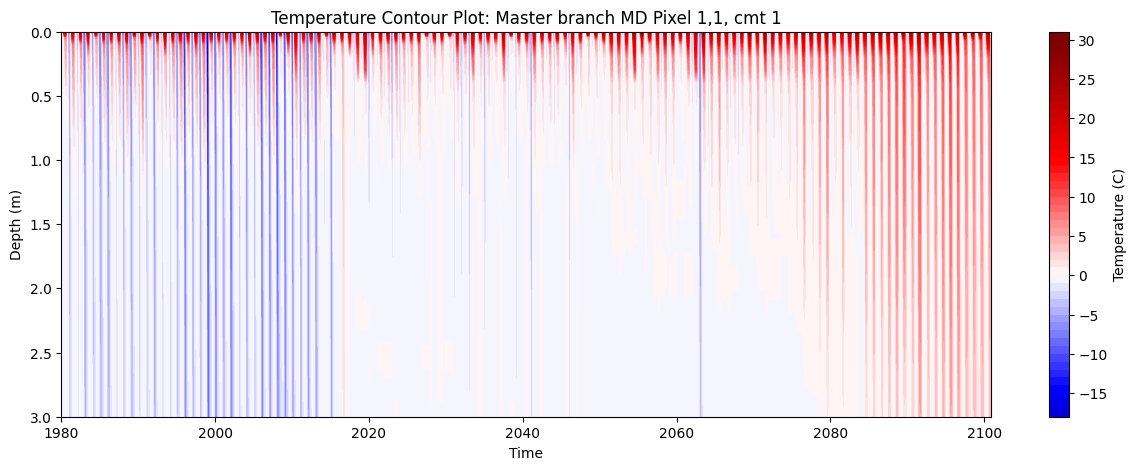

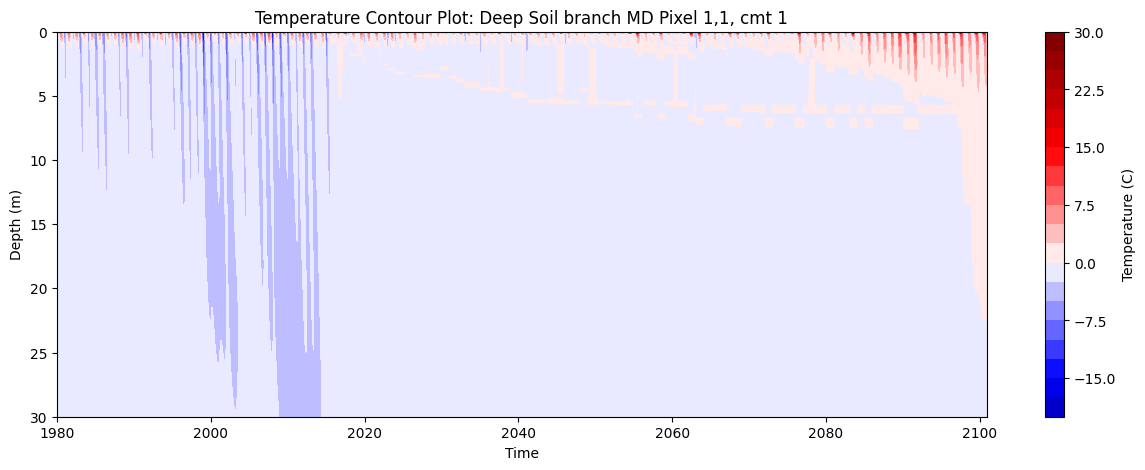

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path = '/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
ds.soil_contourbydepth(data_path,'TLAYER','monthly',1,1,'output', start_time='1980-01-01', end_time='2100-12-31', depth_start=0, 
                    depth_end=3, n=50)
plt.title('Temperature Contour Plot: Master branch MD Pixel 1,1, cmt 1')

##Experiment:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/'
ds.soil_contourbydepth(data_path,'TLAYER','monthly',1,1,'output', start_time='1980-01-01', end_time='2100-12-31', depth_start=0, 
                    depth_end=30, n=20)
plt.title('Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')


Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc


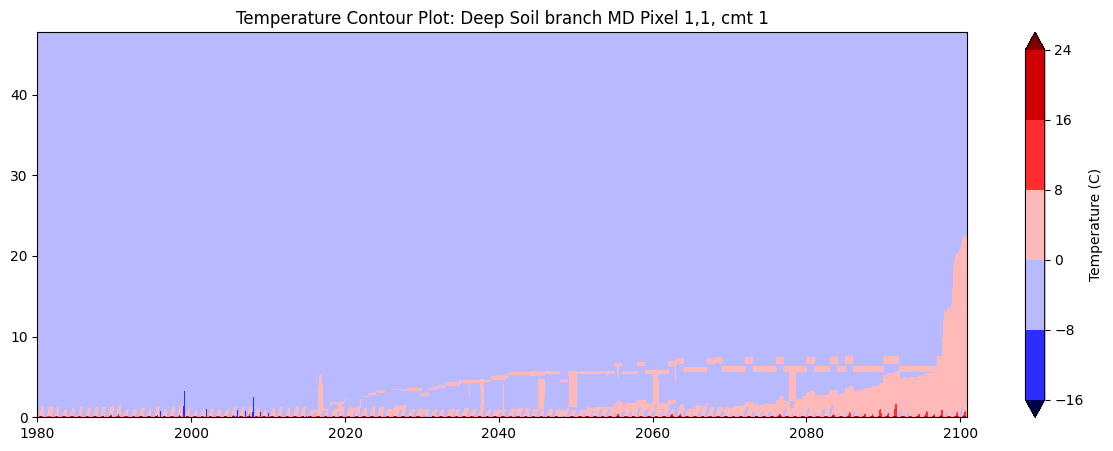

In [7]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/'
output_var='TLAYER'
res='monthly'
px=1
py=1
output_folder='output'
start_time='1980-01-01'
end_time='2100-12-31'
depth_start=0
depth_end=30
n=6
plt.title('Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')

# def soil_contourbydepth(data_path,output_var,res,px,py,output_folder, start_time=None, end_time=None, 
#               depth_start=None, depth_end=None, n=100):

os.chdir(data_path)
df, meta = load_trsc_dataframe(var=output_var, timeres=res, px_y=py, px_x=px, fileprefix=output_folder) 
df_depth, meta_depth = load_trsc_dataframe(var='LAYERDEPTH',  timeres=res, px_y=py, px_x=px, fileprefix=output_folder)
df_dz, meta_dzh = load_trsc_dataframe(var='LAYERDZ',  timeres=res, px_y=py, px_x=px, fileprefix=output_folder)

layers = df.columns.astype(float)
times = pd.to_datetime(df.index)

# Filter data based on start_time and end_time
if start_time is not None and end_time is not None:
    mask = (times >= start_time) & (times <= end_time)
    df = df.loc[mask]
    times = times[mask]

# Extract necessary data
depths = df_depth.iloc[:, :-2].values
dz = df_dz.iloc[:, :-2].values
temperature = df.iloc[:, :-2].values
xp = depths + dz / 2  # Center of each layer, x-coordinates of the data points for interp1d

# Create a regular grid of depth values
ii=np.unravel_index(np.argmax(depths), depths.shape)
maxd=depths.max()+(dz[ii]/2)
regular_depths = np.arange(0, maxd, 0.01)

# Interpolate temperature onto the regular grid
interp_temperature = np.empty((temperature.shape[0], regular_depths.shape[0]))
for i in range(temperature.shape[0]):
    f = interp1d(xp[i], temperature[i], kind='linear', fill_value='extrapolate')
    interp_temperature[i] = f(regular_depths)

# Create contour plot
color_axes = max(np.max(temperature), np.abs(np.min(temperature)))
vmax=color_axes
vmin=-vmax
levels = np.linspace(vmin, vmax, n + 1)

plt.contourf(times, regular_depths, interp_temperature.T, cmap='seismic', vmin=vmin, vmax=vmax, levels=n, extend='both')
plt.colorbar(label='Temperature (C)')


In [8]:
vmin

-29.17885230584002

Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc


Text(0.5, 1.0, 'Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')

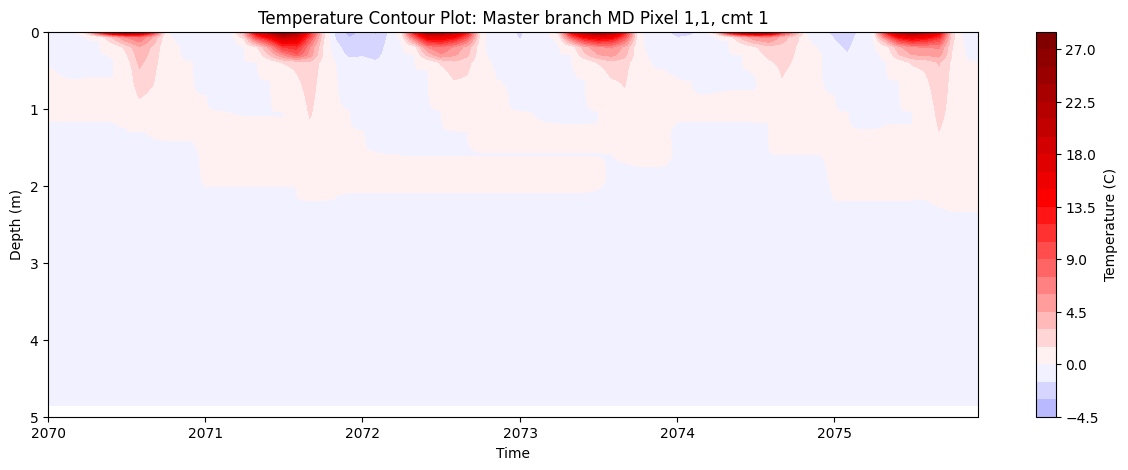

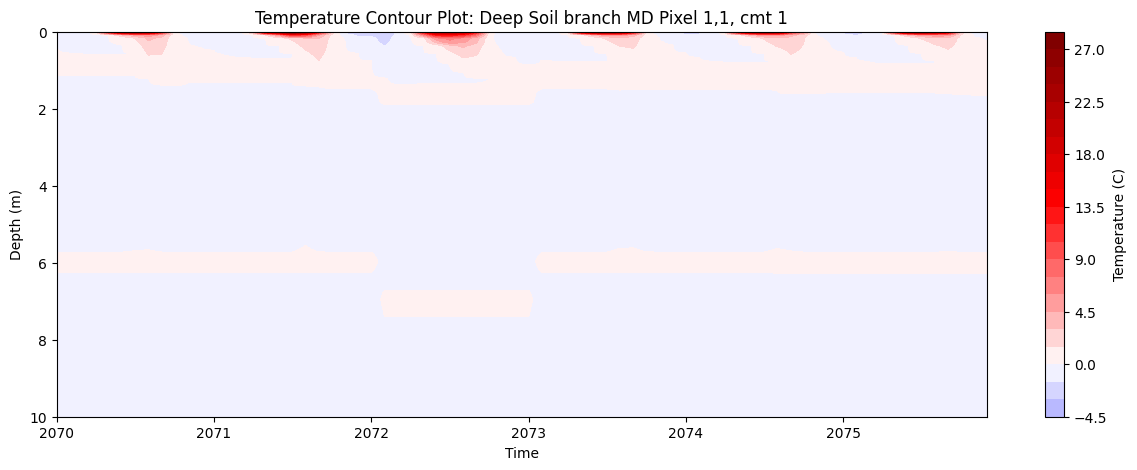

In [4]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path = '/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
soil_contourbydepth(data_path,'TLAYER','monthly',1,1,'output', start_time='2070-01-01', end_time='2075-12-31', depth_start=0, 
                    depth_end=5, n=30)
plt.title('Temperature Contour Plot: Master branch MD Pixel 1,1, cmt 1')

##Experiment:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/'
soil_contourbydepth(data_path,'TLAYER','monthly',1,1,'output', start_time='2070-01-01', end_time='2075-12-31', depth_start=0, 
                    depth_end=10, n=30)
plt.title('Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')


The below code uses np.interp to plot by depth, however the interpolation isn't succesfull... many times end up with zero temp

Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc


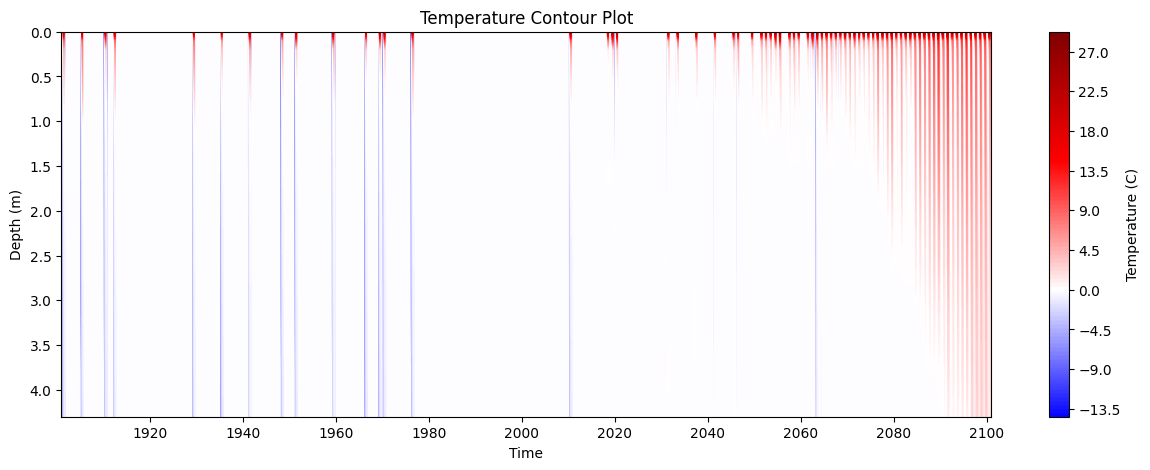

In [50]:
#how to plot correctly by depth?
#how to fix low end of colorbar to value that's less than the lowest temp? (max=-min)
#shifting color by 0.1 around 0C to see shifts better
#manipulate legend for best location?


data_path='/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
os.chdir(data_path)
df, meta = load_trsc_dataframe(var='TLAYER', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_depth, meta_depth = load_trsc_dataframe(var='LAYERDEPTH', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
df_dz, meta_dzh = load_trsc_dataframe(var='LAYERDZ', timeres='monthly', px_y=1, px_x=1, fileprefix='output')

# Assuming you have imported the dataframes `df` and `df_depth`
fig, ax = plt.subplots(1,1,figsize=(15, 5))

# Convert index of `df` to datetime
df.index = pd.to_datetime(df.index)

# Extract necessary data
depths = df_depth.iloc[:,:-2].values
dz = df_dz.iloc[:,:-2].values
times = df.index
temperature = df.iloc[:,:-2].values
xp = (depths + dz/2) #center of each layer,  x-coordinates of the data points for np.interp

# Create a regular grid of depth values
# regular_depths = np.linspace(depths.min(), depths.max(), num=500)  # Adjust the `num` parameter as desired
regular_depths = np.arange(0, depths.max(), 0.1)

# Create meshgrid for depth and time
depth_mesh, time_mesh = np.meshgrid(regular_depths, times)

# Interpolate temperature onto the regular grid
interp_temperature = np.empty_like(depth_mesh)
for i, t in enumerate(times):
    interp_temperature[i, :] = np.interp(regular_depths, xp[i, :], temperature[i, :])

# Create contour plot
color_axes=max(abs(np.max(temperature)),abs(np.min(temperature))) 
plt.contourf(time_mesh, depth_mesh, interp_temperature, cmap='seismic', vmin=-color_axes, vmax=color_axes, levels=400)

# Add colorbar
plt.colorbar(label='Temperature (C)')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Temperature Contour Plot')

# Show the plot
plt.gca().invert_yaxis()

plt.show()


Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc


Text(0.5, 1.0, 'Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')

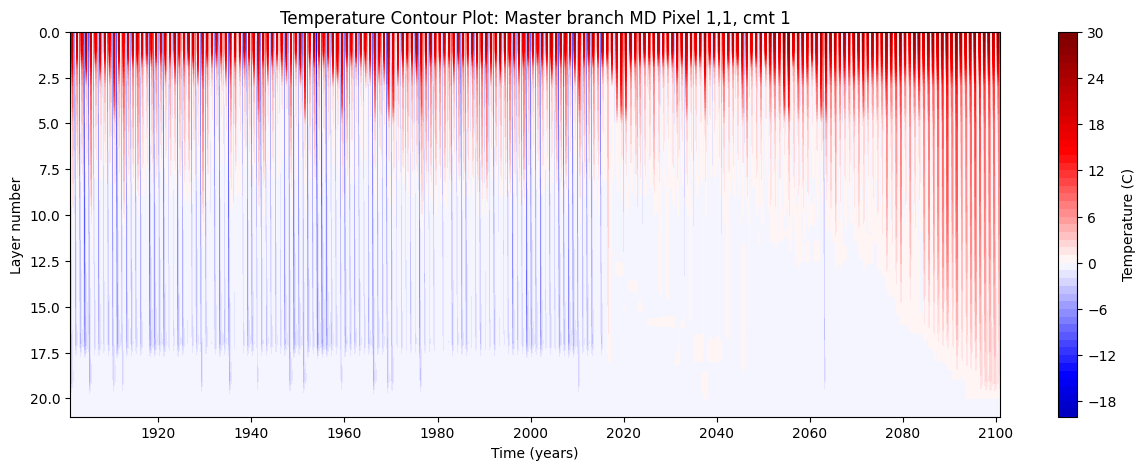

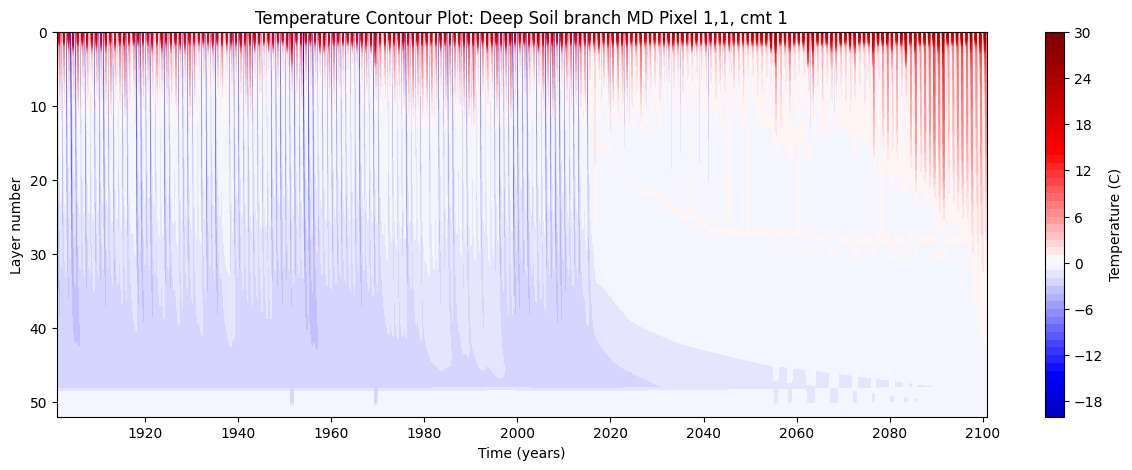

In [2]:
##Control
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
ds.soil_contour(data_path,'TLAYER','monthly',1,1,'output', n=50)
plt.title('Temperature Contour Plot: Master branch MD Pixel 1,1, cmt 1')
# plt.show()

##Experiment:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/'
ds.soil_contour(data_path,'TLAYER','monthly',1,1,'output', n=50)
plt.title('Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')
# plt.show()

Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc


Text(0.5, 1.0, 'Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')

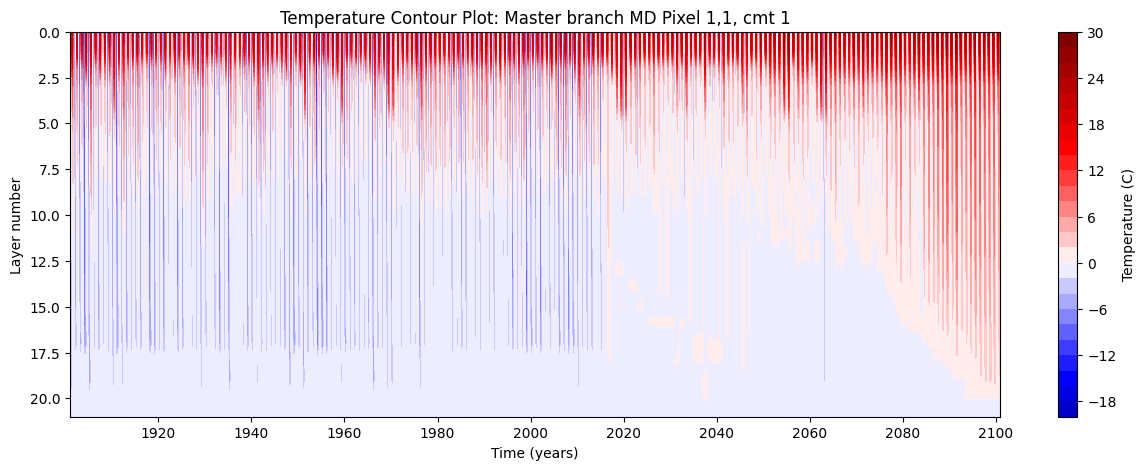

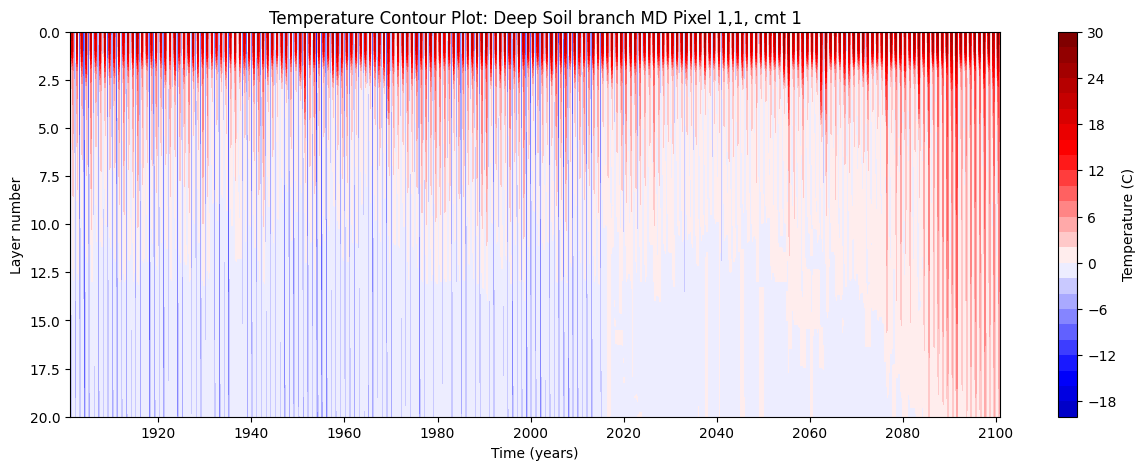

In [4]:
##Control
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
ds.soil_contour(data_path, 'TLAYER', 'monthly', 1, 1, 'output', n=30)
plt.title('Temperature Contour Plot: Master branch MD Pixel 1,1, cmt 1')

##Experiment:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/'
ds.soil_contour(data_path, 'TLAYER', 'monthly', 1, 1, 'output',  
             layer_start=0, layer_end=20, n=30)
plt.title('Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')

Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc


Text(0.5, 1.0, 'Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')

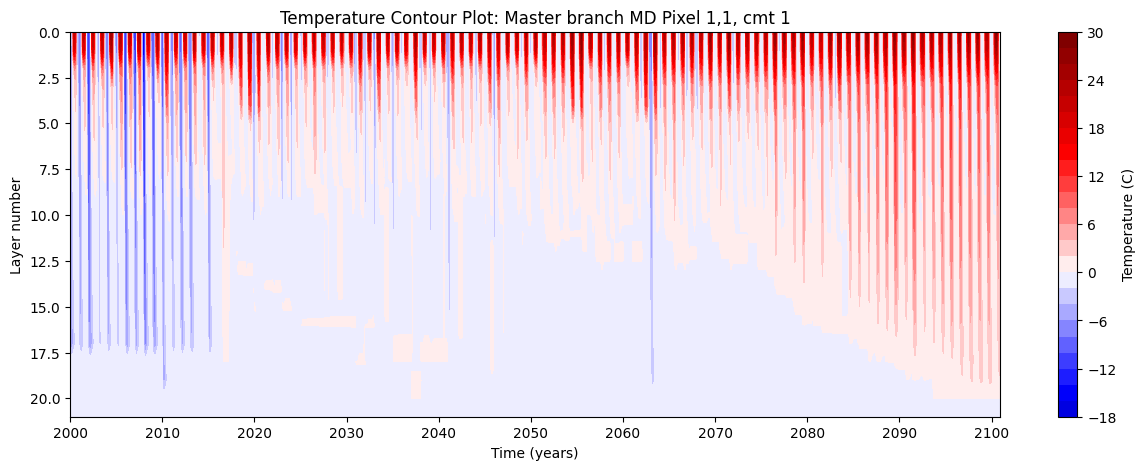

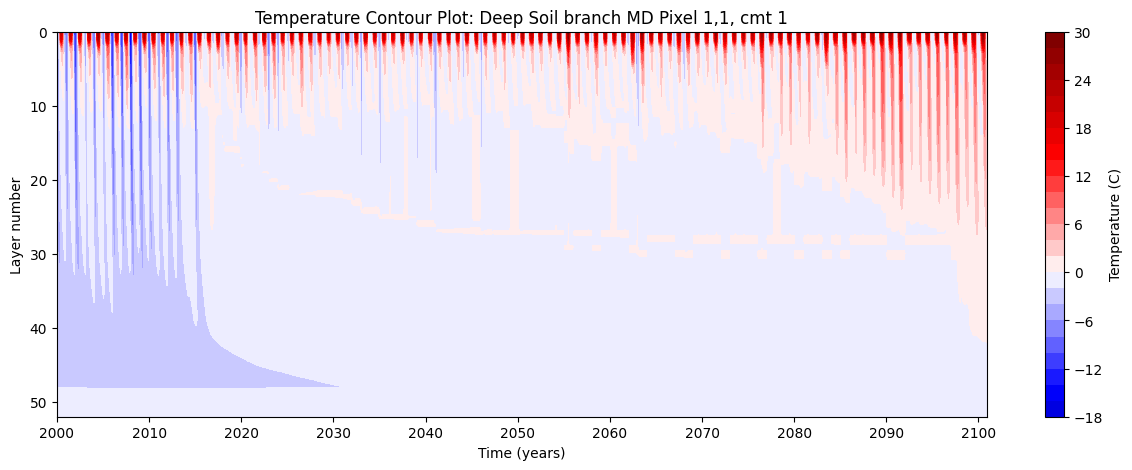

In [5]:
##Control
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
ds.soil_contour(data_path, 'TLAYER', 'monthly', 1, 1, 'output',  start_time='2000-01-01', end_time='2100-12-31',
             n=30)
plt.title('Temperature Contour Plot: Master branch MD Pixel 1,1, cmt 1')

##Experiment:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/'
ds.soil_contour(data_path, 'TLAYER', 'monthly', 1, 1, 'output',  start_time='2000-01-01', end_time='2100-12-31', 
             n=30)
plt.title('Temperature Contour Plot: Deep Soil branch MD Pixel 1,1, cmt 1')

Trying to open:  output/LAYERTYPE_monthly_tr.nc
Trying to open:  output/LAYERTYPE_monthly_sc.nc
Trying to open:  output/LAYERTYPE_monthly_tr.nc
Trying to open:  output/LAYERTYPE_monthly_sc.nc


Text(0.5, 1.0, 'LAYERTYPE Plot: Deep Soil branch MD Pixel 1,1, cmt 1')

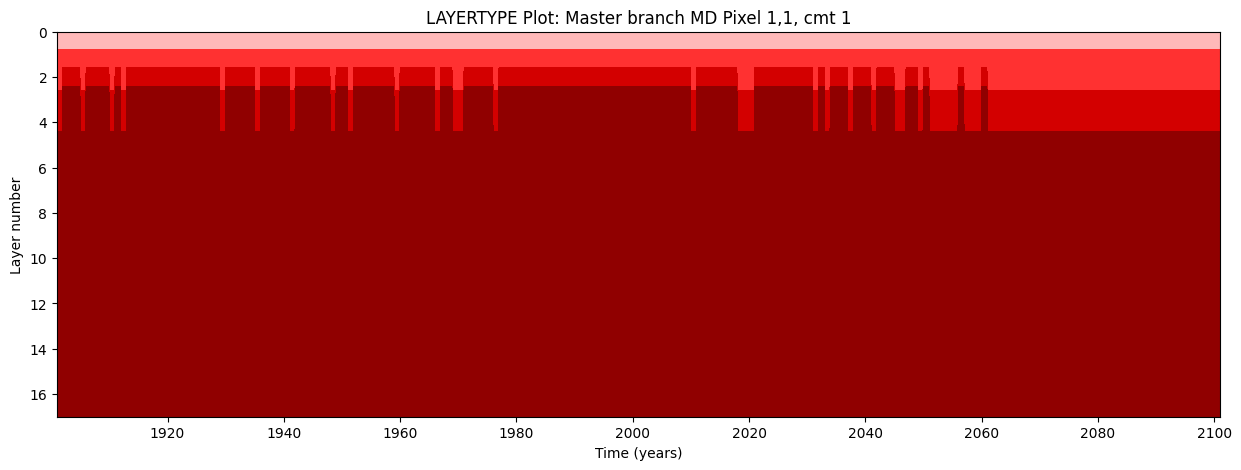

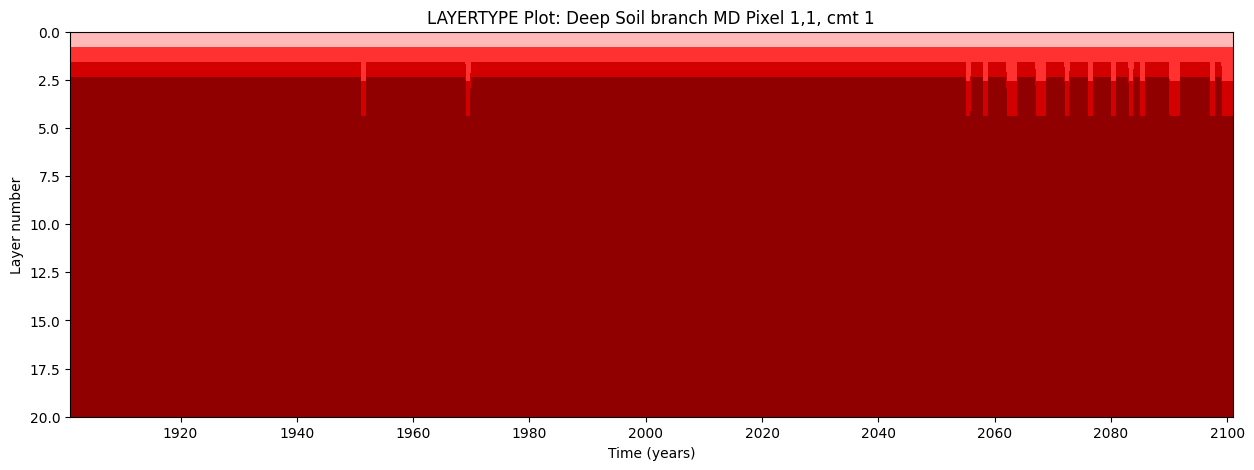

In [6]:
##Control
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/control_allout_monthly_11px/'
ds.layertype_vis(data_path, 'LAYERTYPE', 'monthly', 1, 1, 'output', n=3)
plt.title('LAYERTYPE Plot: Master branch MD Pixel 1,1, cmt 1')

##Experiment:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data_path='/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/'
ds.layertype_vis(data_path, 'LAYERTYPE', 'monthly', 1, 1, 'output',  
             depth_start=0, depth_end=20, n=3)
plt.title('LAYERTYPE Plot: Deep Soil branch MD Pixel 1,1, cmt 1')


## Seasonal Thermal conductivity

Dip starts in 2016, right after ALD jumps. rises again in 2018

Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc
Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc
Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc
Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc


Text(0.5, 1.0, ' MD Pixel 1,1, cmt:1, yearly average')

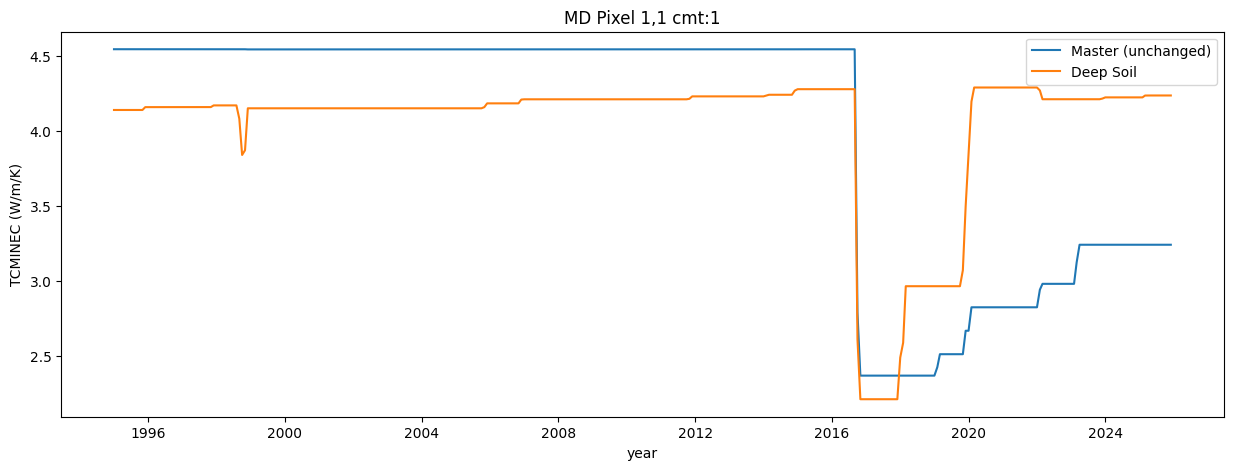

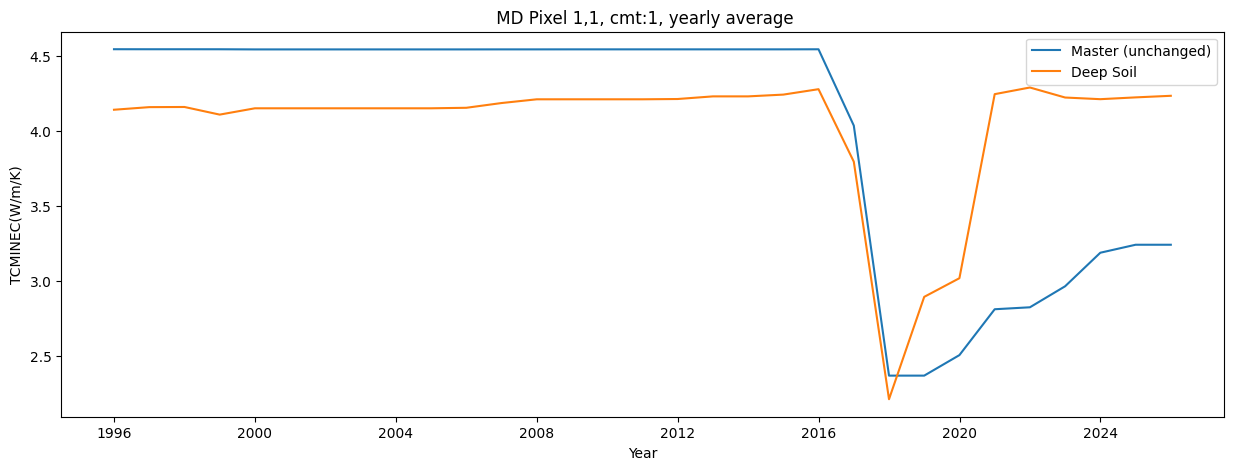

In [9]:
# TCDEEP,Thermal conductivity in amorphous horizon,W/m/K,y,m,,invalid,invalid,invalid,double,
# TCLAYER,Thermal conductivity by layer,W/m/K,y,m,invalid,invalid,invalid,l,double,
# TCMINEA,Thermal conductivity top mineral,W/m/K,y,m,,invalid,invalid,invalid,double,
# TCMINEB,Thermal conductivity middle mineral,W/m/K,y,m,,invalid,invalid,invalid,double,
# TCMINEC,Thermal conductivity bottom mineral,W/m/K,y,m,,invalid,invalid,invalid,double,
# TCSHLW,Thermal conductivity in fibrous horizon,W/m/K,y,m,,invalid,invalid,invalid,double,

fig, ax = plt.subplots(1,1,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TCMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df.loc['1995':'2025'].index, df.loc['1995':'2025'][0], label='TCMINEC')
plt.xlabel('year')
plt.ylabel('TCMINEC ({})'.format(meta['var_units']))
# plt.title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df_ds, meta = load_trsc_dataframe(var='TCMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df_ds.loc['1995':'2025'].index, df_ds.loc['1995':'2025'][0], label='TCMINEC')
plt.xlabel('year')
plt.ylabel('TCMINEC ({})'.format(meta['var_units']))
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title('MD Pixel 1,1 cmt:1')


#PLot for each layer:
folder='MD_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='TCMINEC'
layer=7
year='1995'
end_year='2025'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(' MD Pixel 1,1, cmt:1, yearly average')

Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc
Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc


Text(0.5, 1.0, 'BNZ_deep_soil Pixel 1,1, cmt:1')

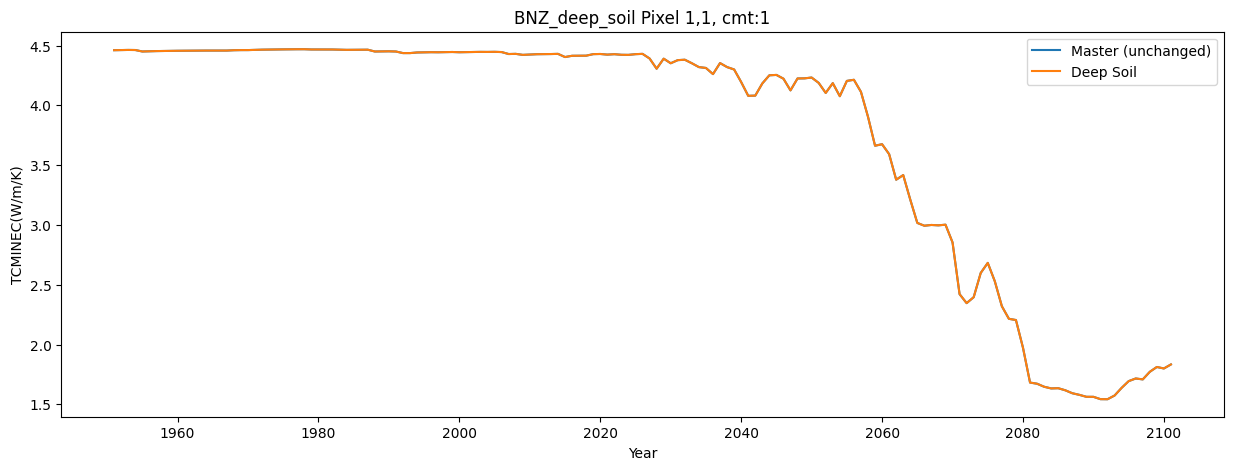

In [15]:
# TCDEEP,Thermal conductivity in amorphous horizon,W/m/K,y,m,,invalid,invalid,invalid,double,
# TCLAYER,Thermal conductivity by layer,W/m/K,y,m,invalid,invalid,invalid,l,double,
# TCMINEA,Thermal conductivity top mineral,W/m/K,y,m,,invalid,invalid,invalid,double,
# TCMINEB,Thermal conductivity middle mineral,W/m/K,y,m,,invalid,invalid,invalid,double,
# TCMINEC,Thermal conductivity bottom mineral,W/m/K,y,m,,invalid,invalid,invalid,double,
# TCSHLW,Thermal conductivity in fibrous horizon,W/m/K,y,m,,invalid,invalid,invalid,double,


#PLot for each layer:
folder='BNZ_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='TCMINEC'
layer=7
year='1950'
end_year='2100'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1, cmt:1')

Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc
Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc


Text(0.5, 1.0, 'Seasonal TCMINEC, Master Branch')

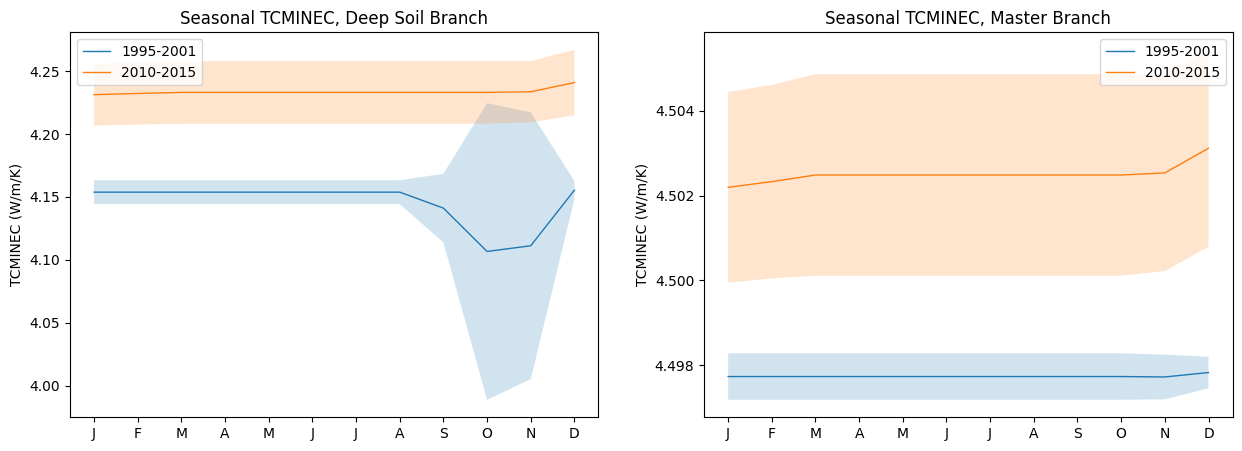

In [75]:
#SEASONAL Temp and thermal conductivity, minec

fig, ax = plt.subplots(1,2,figsize=(15, 5))

os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TCMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
for time_period in ['1995-2001','2010-2015']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[0].plot(mean, linewidth=1, label=time_period)
  ax[0].fill_between(mean.index, mean - std, mean + std, alpha=0.2)
  ax[0].set_ylabel('TCMINEC ({})'.format(meta['var_units']))
  ax[0].legend()
ax[0].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[0].set_title('Seasonal TCMINEC, Deep Soil Branch')

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TCMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
for time_period in ['1995-2001','2010-2015']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[1].plot(mean, linewidth=1, label=time_period)
  ax[1].fill_between(mean.index, mean - std, mean + std, alpha=0.2)
  ax[1].set_ylabel('TCMINEC ({})'.format(meta['var_units']))
  ax[1].legend()
ax[1].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[1].set_title('Seasonal TCMINEC, Master Branch')

Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc
Trying to open:  output/TCMINEC_monthly_tr.nc
Trying to open:  output/TCMINEC_monthly_sc.nc


Text(0.5, 1.0, 'Seasonal TCMINEC, Master Branch')

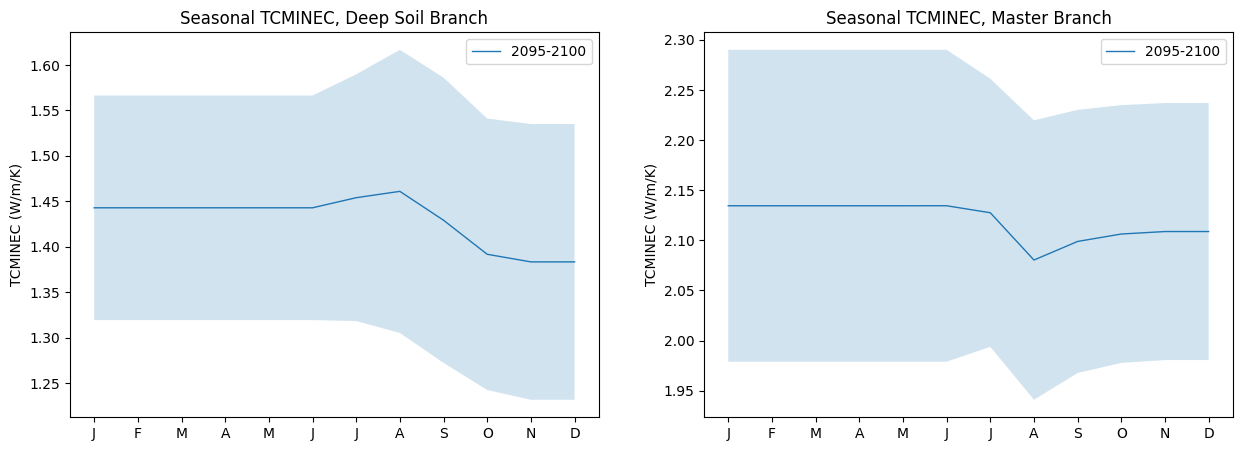

In [76]:
#SEASONAL Temp and thermal conductivity, minec

fig, ax = plt.subplots(1,2,figsize=(15, 5))

os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TCMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
for time_period in ['2095-2100']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[0].plot(mean, linewidth=1, label=time_period)
  ax[0].fill_between(mean.index, mean - std, mean + std, alpha=0.2)
  ax[0].set_ylabel('TCMINEC ({})'.format(meta['var_units']))
  ax[0].legend()
ax[0].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[0].set_title('Seasonal TCMINEC, Deep Soil Branch')

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TCMINEC', timeres='monthly',px_y=1, px_x=1, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
for time_period in ['2095-2100']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[1].plot(mean, linewidth=1, label=time_period)
  ax[1].fill_between(mean.index, mean - std, mean + std, alpha=0.2)
  ax[1].set_ylabel('TCMINEC ({})'.format(meta['var_units']))
  ax[1].legend()
ax[1].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[1].set_title('Seasonal TCMINEC, Master Branch')

Trying to open:  output/QDRAINAGE_monthly_tr.nc
Trying to open:  output/QDRAINAGE_monthly_sc.nc
Trying to open:  output/QDRAINAGE_monthly_tr.nc
Trying to open:  output/QDRAINAGE_monthly_sc.nc


Text(0.5, 1.0, 'MD Pixel 3,4')

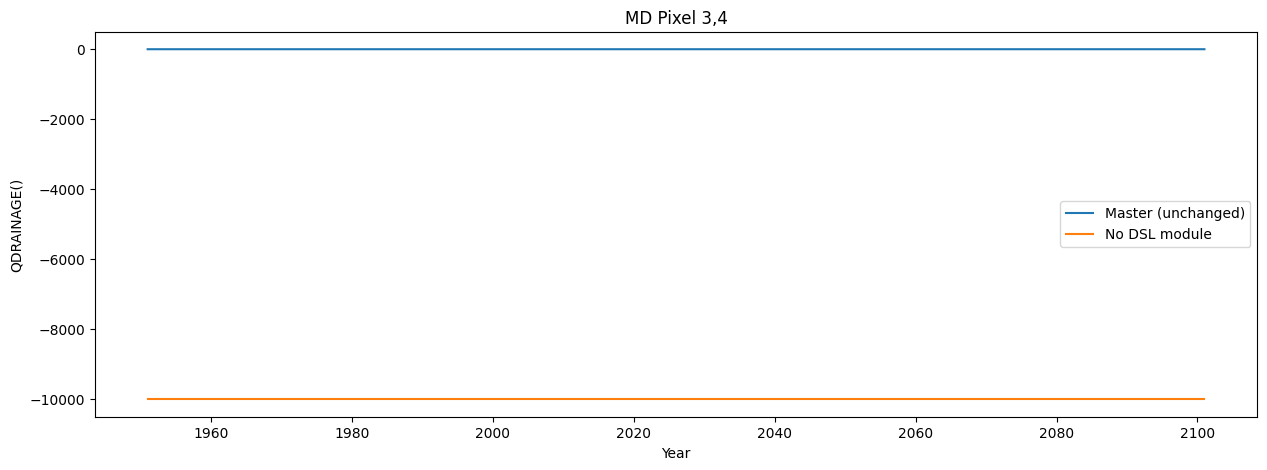

In [121]:
folder='MD_deep_soil'
run_folder_control='control_allout_monthly_34px'
# run_folder_experiment='control_allout_monthly_34px_nodsl'
output_var='SHLWC'
layer=2
year='1950'
end_year='2100'
px_y=3
px_x=4

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, 'monthly', output_var, px_y, px_x, layer, year, end_year)
# plot_data(folder, run_folder_experiment, 'monthly', 'LAYERDEPTH', px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'No DSL module'])
plt.title('MD Pixel 3,4')

## TMINEC

Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc


Text(0.5, 1.0, 'MD_deep_soil Pixel 1,1, yearly average')

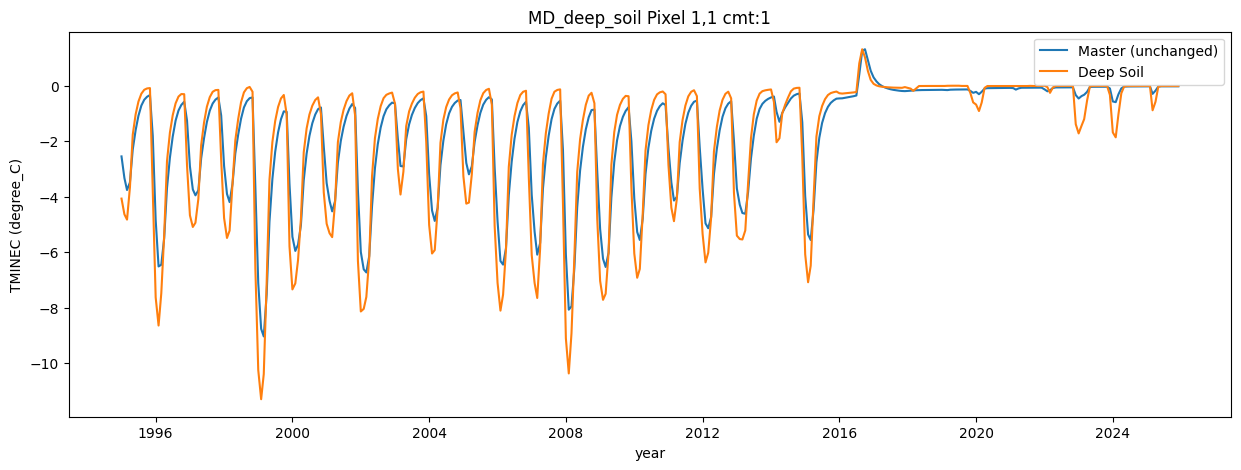

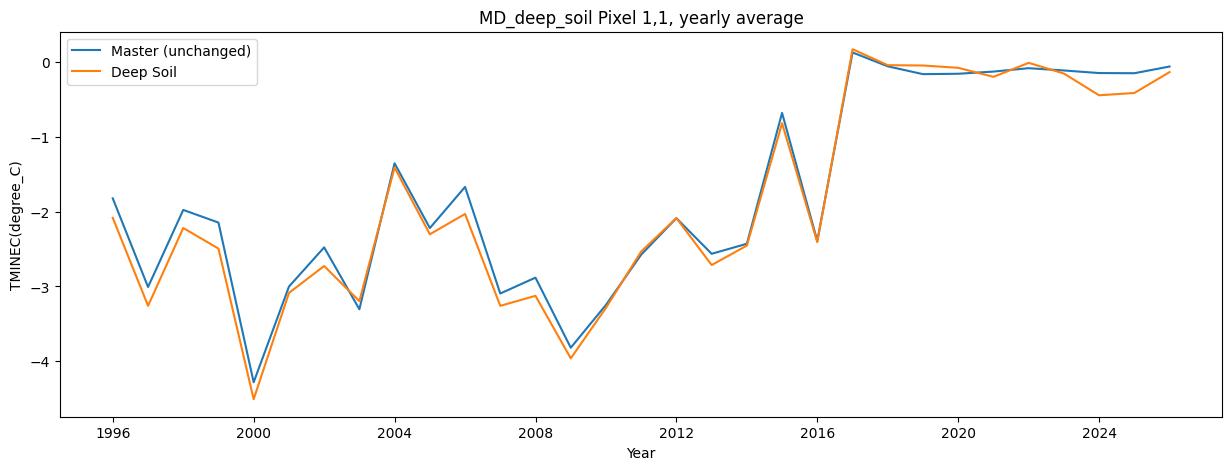

In [10]:
#Plot TMINEC

fig, ax = plt.subplots(1,1,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df.loc['1995':'2025'].index, df.loc['1995':'2025'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('TMINEC ({})'.format(meta['var_units']))
# plt.title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df_ds, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df_ds.loc['1995':'2025'].index, df_ds.loc['1995':'2025'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('TMINEC ({})'.format(meta['var_units']))
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1 cmt:1')

folder='MD_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='TMINEC'
layer=0
year='1995'
end_year='2025'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1, yearly average')

Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc
Trying to open:  output/TMINEC_monthly_tr.nc
Trying to open:  output/TMINEC_monthly_sc.nc


Text(0.5, 1.0, 'BNZ_deep_soil Pixel 1,1, yearly average')

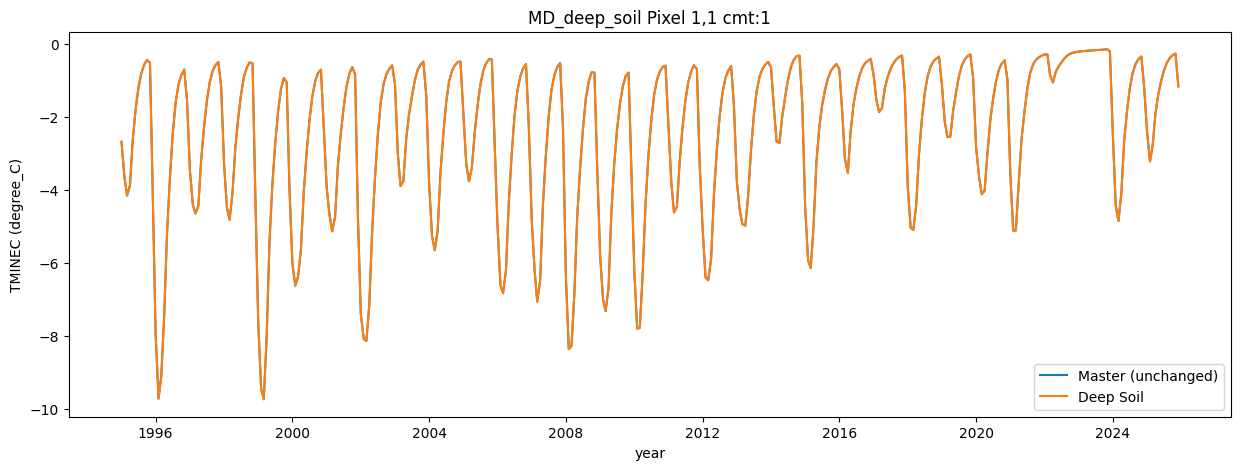

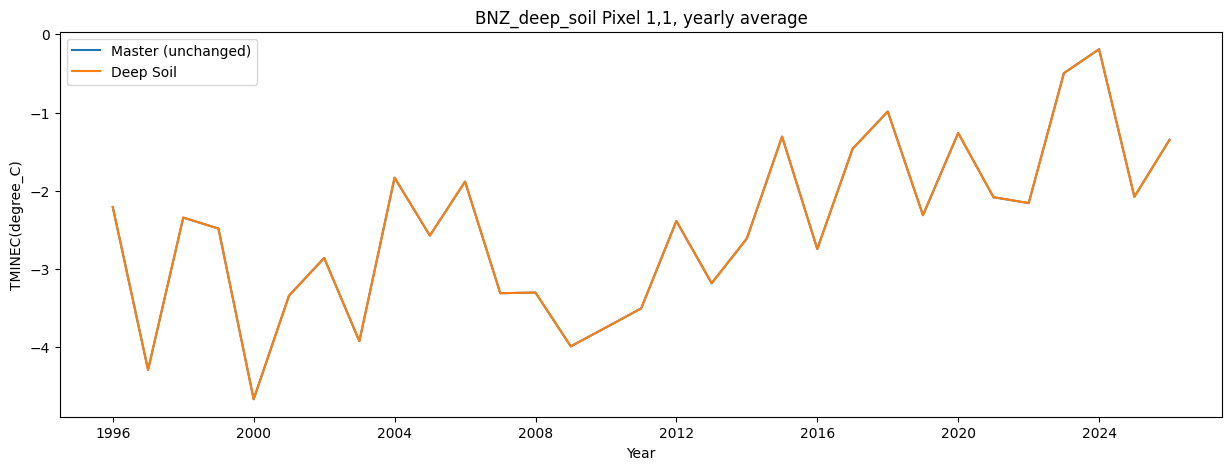

In [11]:
#Plot TMINEC

fig, ax = plt.subplots(1,1,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/BNZ_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df.loc['1995':'2025'].index, df.loc['1995':'2025'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('TMINEC ({})'.format(meta['var_units']))
# plt.title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/BNZ_deep_soil/experiment_allout_monthly_11px/')
df_ds, meta = load_trsc_dataframe(var='TMINEC', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df_ds.loc['1995':'2025'].index, df_ds.loc['1995':'2025'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('TMINEC ({})'.format(meta['var_units']))
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1 cmt:1')

folder='BNZ_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='TMINEC'
layer=0
year='1995'
end_year='2025'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title(folder+' Pixel 1,1, yearly average')

# EET and PET

Trying to open:  output/EET_monthly_tr.nc
Trying to open:  output/EET_monthly_sc.nc
Trying to open:  output/EET_monthly_tr.nc
Trying to open:  output/EET_monthly_sc.nc
Trying to open:  output/EET_monthly_tr.nc
Trying to open:  output/EET_monthly_sc.nc
Trying to open:  output/EET_monthly_tr.nc
Trying to open:  output/EET_monthly_sc.nc


Text(0.5, 1.0, 'MD Pixel 1,1, yearly average')

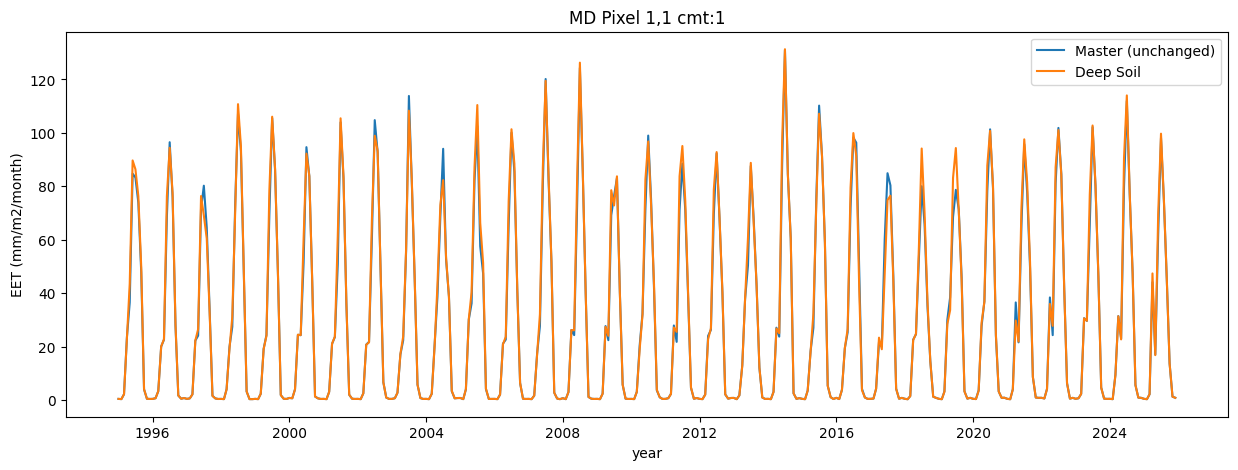

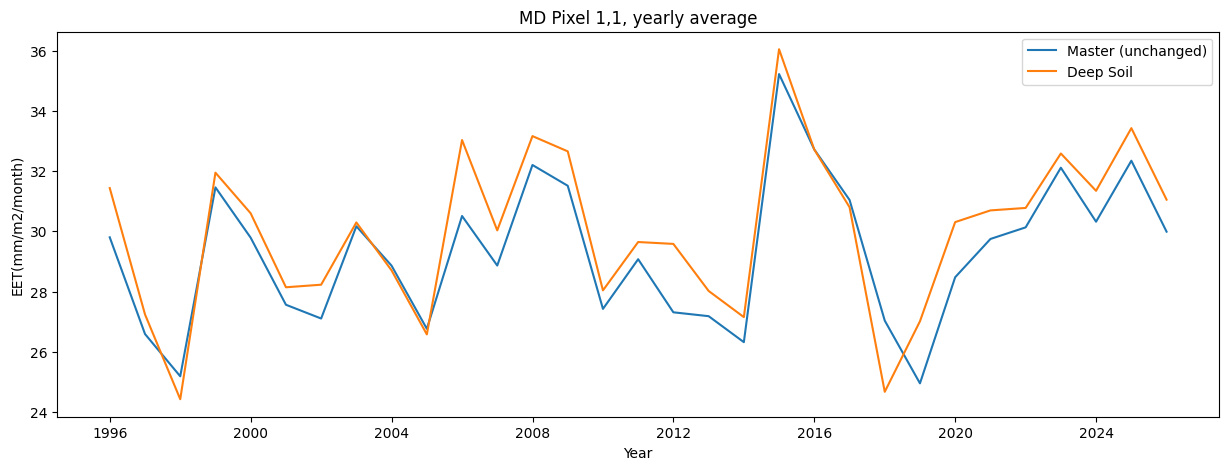

In [28]:
#EET is NOT by layer
#EET,Actual ET,mm/m2/time

fig, ax = plt.subplots(1,1,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='EET', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df.loc['1995':'2025'].index, df.loc['1995':'2025'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('EET ({})'.format(meta['var_units']))
# plt.title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df_ds, meta = load_trsc_dataframe(var='EET', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df_ds.loc['1995':'2025'].index, df_ds.loc['1995':'2025'][0], label='TMINEC')
plt.xlabel('year')
plt.ylabel('EET ({})'.format(meta['var_units']))
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title('MD Pixel 1,1 cmt:1')

folder='MD_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='EET'
layer=0
year='1995'
end_year='2025'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title('MD Pixel 1,1, yearly average')

Trying to open:  output/PET_monthly_tr.nc
Trying to open:  output/PET_monthly_sc.nc
Trying to open:  output/PET_monthly_tr.nc
Trying to open:  output/PET_monthly_sc.nc
Trying to open:  output/PET_monthly_tr.nc
Trying to open:  output/PET_monthly_sc.nc
Trying to open:  output/PET_monthly_tr.nc
Trying to open:  output/PET_monthly_sc.nc


Text(0.5, 1.0, 'MD Pixel 1,1, yearly average')

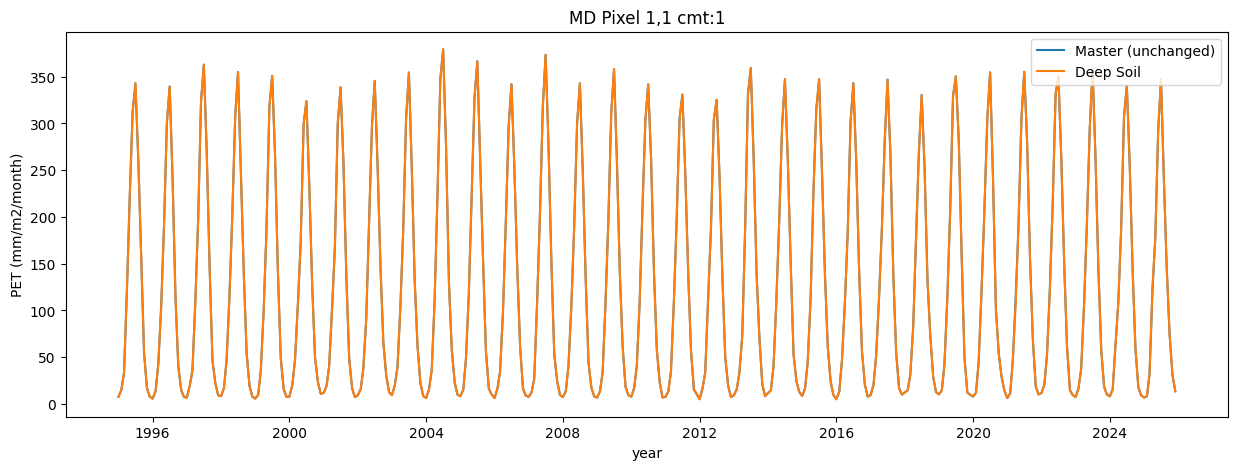

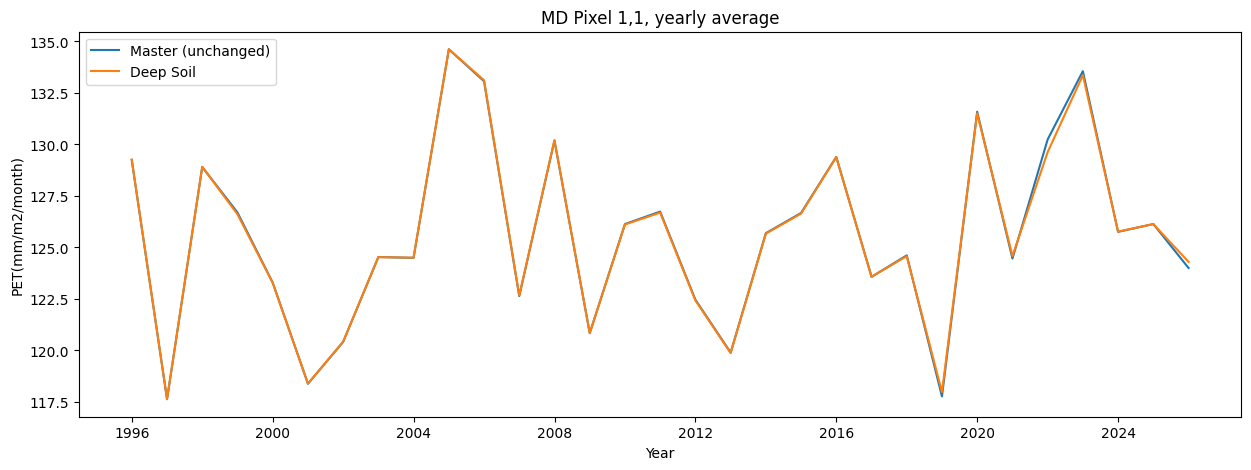

In [31]:
#EET is NOT by layer

fig, ax = plt.subplots(1,1,figsize=(15, 5))

#Plot master branch run
os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
df, meta = load_trsc_dataframe(var='PET', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df.loc['1995':'2025'].index, df.loc['1995':'2025'][0], label='PET')
plt.xlabel('year')
plt.ylabel('PET ({})'.format(meta['var_units']))
# plt.title('Master branch')

#plot deep soil branch run
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
df_ds, meta = load_trsc_dataframe(var='PET', timeres='monthly', px_y=1, px_x=1, fileprefix='output')
plt.plot(df_ds.loc['1995':'2025'].index, df_ds.loc['1995':'2025'][0], label='PET')
plt.xlabel('year')
plt.ylabel('PET ({})'.format(meta['var_units']))
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title('MD Pixel 1,1 cmt:1')

folder='MD_deep_soil'
run_folder_control='control_allout_monthly_11px'
run_folder_experiment='experiment_allout_monthly_11px'
output_var='PET'
layer=0
year='1995'
end_year='2025'
px_y=1
px_x=1

fig, ax = plt.subplots(1,1,figsize=(15, 5))

ds.plot_data(folder, run_folder_control, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ds.plot_data(folder, run_folder_experiment, 'monthly', output_var, px_y, px_x, layer, year, end_year)
ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title('MD Pixel 1,1, yearly average')

In [29]:
PET

0
1901-01-01    6.129268
1901-02-01   11.307504
1901-03-01   38.381900
1901-04-01   99.581508
1901-05-01  166.662808
...                ...
2100-08-01  331.911216
2100-09-01  181.919584
2100-10-01   84.971823
2100-11-01   33.100317
2100-12-01   13.808048

[2400 rows x 1 columns]

# Seasonal RH

Note RH is a function of soil moisture and temperature:

RH = Kd * CS * f(MV) * e(0.069 * Ts)

Kd = rate of decomposition at 0°C, 
CS = soil carbon stock, 
MV = mean volumetric monthly soil moisture, 
Ts = mean soil temperature

Trying to open:  output/RH_monthly_tr.nc
Trying to open:  output/RH_monthly_sc.nc
Trying to open:  output/RH_monthly_tr.nc
Trying to open:  output/RH_monthly_sc.nc


Text(0.5, 1.0, 'Seasonal RH, Master Branch')

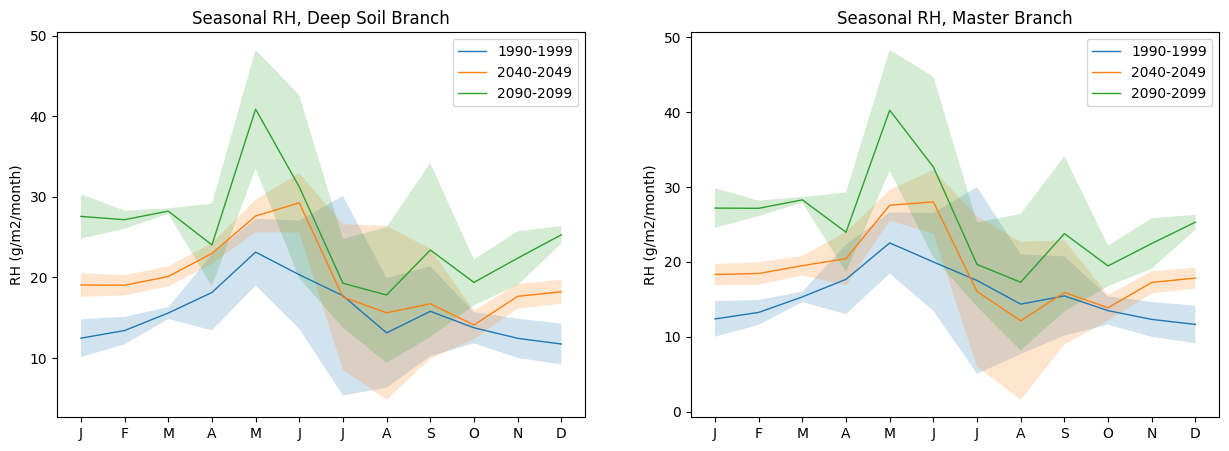

In [7]:
#SEASONAL RH

fig, ax = plt.subplots(1,2,figsize=(15, 5))

os.chdir('/data/workflows/MD_deep_soil/experiment')
df, meta = load_trsc_dataframe(var='RH', timeres='monthly',px_y=0, px_x=0, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
for time_period in ['1990-1999','2040-2049', '2090-2099']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[0].plot(mean, linewidth=1, label=time_period)
  ax[0].fill_between(mean.index, mean - std, mean + std, alpha=0.2)
  ax[0].set_ylabel('RH ({})'.format(meta['var_units']))
  ax[0].legend()
ax[0].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[0].set_title('Seasonal RH, Deep Soil Branch')

os.chdir('/data/workflows/MD_deep_soil/control')
df, meta = load_trsc_dataframe(var='RH', timeres='monthly',px_y=0, px_x=0, fileprefix='output')
# sum across PFTs...
ecosystem_sum = df.sum(axis=1)
for time_period in ['1990-1999','2040-2049', '2090-2099']:
  startyr, endyr = time_period.split('-')
  # The result is a pandas.Series
  range_series = ecosystem_sum[startyr:endyr]
  mean = range_series.groupby(range_series.index.month).mean()
  std =  range_series.groupby(range_series.index.month).std()
  ax[1].plot(mean, linewidth=1, label=time_period)
  ax[1].fill_between(mean.index, mean - std, mean + std, alpha=0.2)
  ax[1].set_ylabel('RH ({})'.format(meta['var_units']))
  ax[1].legend()
ax[1].set_xticks(range(1,13), 'J,F,M,A,M,J,J,A,S,O,N,D'.split(','))
ax[1].set_title('Seasonal RH, Master Branch')

### Trumpet Plots

plots var over depth for given resolutions and time periods

Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc


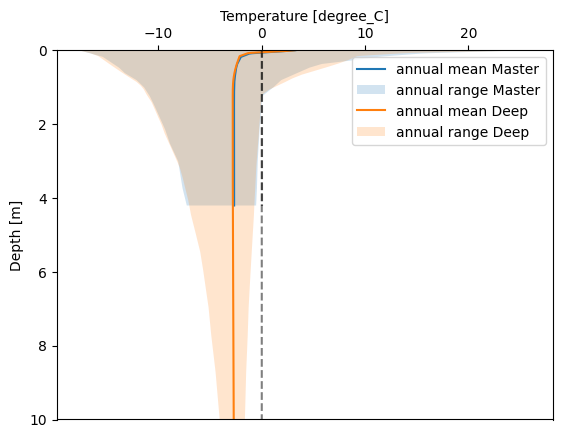

In [4]:
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
px = 1; py = 1
LAYERDEPTH, ld_units = load_trsc_dataframe(var="LAYERDEPTH", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')
LAYERDZ, lz_units = load_trsc_dataframe(var="LAYERDZ", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')
TLAYER, t_units = load_trsc_dataframe(var="TLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
LAYERDEPTH_master, ld_units_master = load_trsc_dataframe(var="LAYERDEPTH", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')
LAYERDZ_master, lz_units_master = load_trsc_dataframe(var="LAYERDZ", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')
TLAYER_master, t_units_master = load_trsc_dataframe(var="TLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')


fig, ax = plt.subplots()

dep, avg, std, mn, mx = ds.seasonal_profile(TLAYER_master, LAYERDEPTH_master, LAYERDZ_master, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# fig, ax = plt.subplots()
x=dep
ax.plot(avg, dep, label="annual mean Master")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="annual range Master")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

dep, avg, std, mn, mx = ds.seasonal_profile(TLAYER, LAYERDEPTH, LAYERDZ, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
x=dep
ax.plot(avg, dep, label="annual mean Deep")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="annual range Deep")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)


ax.xaxis.tick_top()
ax.set_xlabel(f"Temperature [{t_units['var_units']}]")
ax.xaxis.set_label_position('top') 

ax.set_ylabel(f"Depth [{ld_units['var_units']}]")
ax.set_ylim(0, 10)
ax.invert_yaxis()
ax.legend()

Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc
Trying to open:  output/TCLAYER_monthly_tr.nc
Trying to open:  output/TCLAYER_monthly_sc.nc
Trying to open:  output/TCLAYER_monthly_tr.nc
Trying to open:  output/TCLAYER_monthly_sc.nc


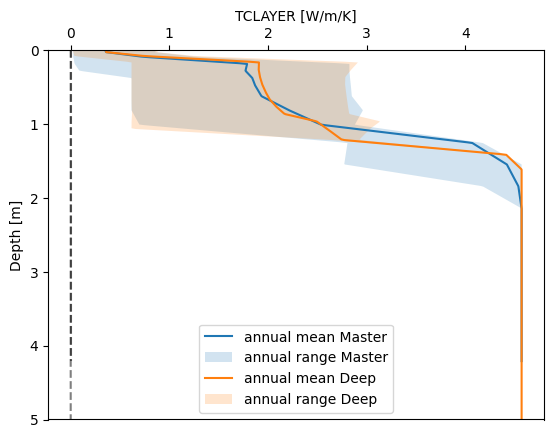

In [5]:
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
px = 1; py = 1
LAYERDEPTH, ld_units = load_trsc_dataframe(var="LAYERDEPTH", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')
LAYERDZ, lz_units = load_trsc_dataframe(var="LAYERDZ", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')
TCLAYER, t_units = load_trsc_dataframe(var="TCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
TCLAYER_master, t_units_master = load_trsc_dataframe(var="TCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

fig, ax = plt.subplots()

dep, avg, std, mn, mx = ds.seasonal_profile(TCLAYER_master, LAYERDEPTH_master, LAYERDZ_master, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# fig, ax = plt.subplots()
x=dep
ax.plot(avg, dep, label="annual mean Master")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="annual range Master")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

dep, avg, std, mn, mx = ds.seasonal_profile(TCLAYER, LAYERDEPTH, LAYERDZ, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
x=dep
ax.plot(avg, dep, label="annual mean Deep")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="annual range Deep")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

ax.xaxis.tick_top()
ax.set_xlabel(f"TCLAYER [{t_units['var_units']}]")
ax.xaxis.set_label_position('top') 

ax.set_ylabel(f"Depth [{ld_units['var_units']}]")
ax.set_ylim(0, 5)
ax.invert_yaxis()
ax.legend()

Trying to open:  output/LAYERDEPTH_monthly_tr.nc
Trying to open:  output/LAYERDEPTH_monthly_sc.nc
Trying to open:  output/LAYERDZ_monthly_tr.nc
Trying to open:  output/LAYERDZ_monthly_sc.nc
Trying to open:  output/TLAYER_monthly_tr.nc
Trying to open:  output/TLAYER_monthly_sc.nc
Trying to open:  output/IWCLAYER_monthly_tr.nc
Trying to open:  output/IWCLAYER_monthly_sc.nc


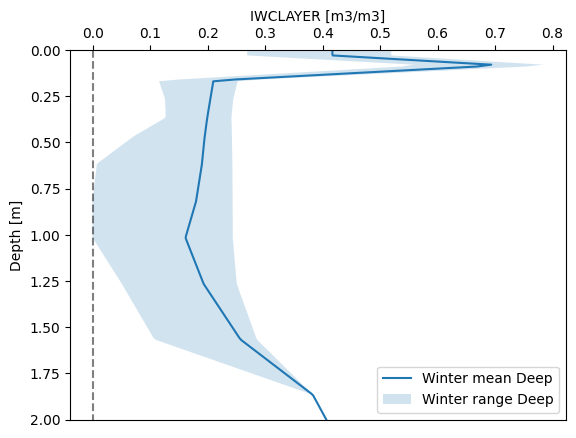

In [8]:
os.chdir('/data/workflows/MD_deep_soil/nfactorw0.75_hk02_monthly_11px/')
px = 1; py = 1
LAYERDEPTH, ld_units = load_trsc_dataframe(var="LAYERDEPTH", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')
LAYERDZ, lz_units = load_trsc_dataframe(var="LAYERDZ", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')
TLAYER, t_units = load_trsc_dataframe(var="TLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')
px = 1; py = 1
IWCLAYER, t_units = load_trsc_dataframe(var="IWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

# os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
# IWCLAYER_master, t_units_master = load_trsc_dataframe(var="IWCLAYER", timeres='monthly', px_y=py,
#                                                  px_x=px, fileprefix='output')

fig, ax = plt.subplots()

# dep, avg, std, mn, mx = ds.seasonal_profile(IWCLAYER_master, LAYERDEPTH_master, LAYERDZ_master, 0.01, '2000-2010', 
#                     ['Jan', 'Feb', 'Dec'])
# # fig, ax = plt.subplots()
# x=dep
# ax.plot(avg, dep, label="Winter mean Master")
# ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="Winter range Master")
# ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

dep, avg, std, mn, mx = ds.seasonal_profile(IWCLAYER, LAYERDEPTH, LAYERDZ, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Dec'])
x=dep
ax.plot(avg, dep, label="Winter mean Deep")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="Winter range Deep")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

ax.xaxis.tick_top()
ax.set_xlabel(f"IWCLAYER [{t_units['var_units']}]")
ax.xaxis.set_label_position('top') 

ax.set_ylabel(f"Depth [{ld_units['var_units']}]")
ax.set_ylim(0, 2)
ax.invert_yaxis()
ax.legend()

Trying to open:  output/IWCLAYER_monthly_tr.nc
Trying to open:  output/IWCLAYER_monthly_sc.nc
Trying to open:  output/IWCLAYER_monthly_tr.nc
Trying to open:  output/IWCLAYER_monthly_sc.nc


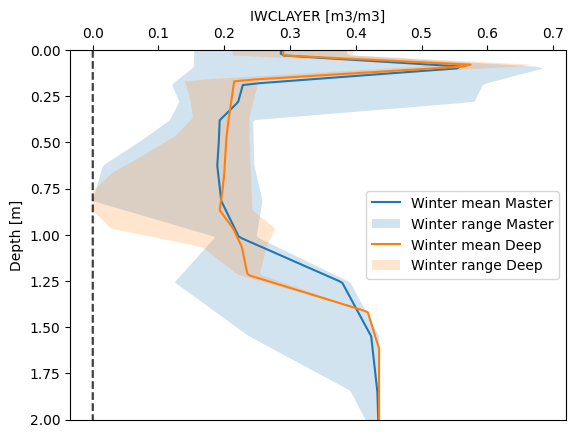

In [6]:
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
px = 1; py = 1
IWCLAYER, t_units = load_trsc_dataframe(var="IWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
IWCLAYER_master, t_units_master = load_trsc_dataframe(var="IWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

fig, ax = plt.subplots()

dep, avg, std, mn, mx = ds.seasonal_profile(IWCLAYER_master, LAYERDEPTH_master, LAYERDZ_master, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Dec'])
# fig, ax = plt.subplots()
x=dep
ax.plot(avg, dep, label="Winter mean Master")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="Winter range Master")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

dep, avg, std, mn, mx = ds.seasonal_profile(IWCLAYER, LAYERDEPTH, LAYERDZ, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Dec'])
x=dep
ax.plot(avg, dep, label="Winter mean Deep")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="Winter range Deep")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

ax.xaxis.tick_top()
ax.set_xlabel(f"IWCLAYER [{t_units['var_units']}]")
ax.xaxis.set_label_position('top') 

ax.set_ylabel(f"Depth [{ld_units['var_units']}]")
ax.set_ylim(0, 2)
ax.invert_yaxis()
ax.legend()

Trying to open:  output/LWCLAYER_monthly_tr.nc
Trying to open:  output/LWCLAYER_monthly_sc.nc
Trying to open:  output/LWCLAYER_monthly_tr.nc
Trying to open:  output/LWCLAYER_monthly_sc.nc


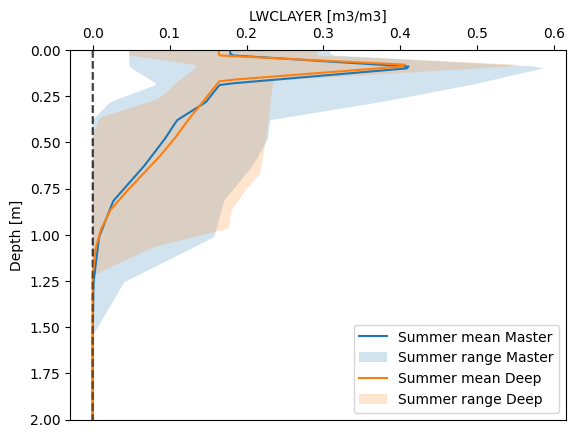

In [7]:
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
px = 1; py = 1
LWCLAYER, t_units = load_trsc_dataframe(var="LWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
LWCLAYER_master, t_units_master = load_trsc_dataframe(var="LWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

fig, ax = plt.subplots()

dep, avg, std, mn, mx = ds.seasonal_profile(LWCLAYER_master, LAYERDEPTH_master, LAYERDZ_master, 0.01, '2000-2010', 
                    ['Jun', 'Jul', 'Aug'])
# fig, ax = plt.subplots()
x=dep
ax.plot(avg, dep, label="Summer mean Master")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="Summer range Master")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

dep, avg, std, mn, mx = ds.seasonal_profile(LWCLAYER, LAYERDEPTH, LAYERDZ, 0.01, '2000-2010', 
                    ['Jun', 'Jul', 'Aug'])
x=dep
ax.plot(avg, dep, label="Summer mean Deep")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="Summer range Deep")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

ax.xaxis.tick_top()
ax.set_xlabel(f"LWCLAYER [{t_units['var_units']}]")
ax.xaxis.set_label_position('top') 

ax.set_ylabel(f"Depth [{ld_units['var_units']}]")
ax.set_ylim(0, 2)
ax.invert_yaxis()
ax.legend()

Trying to open:  output/VWCLAYER_monthly_tr.nc
Trying to open:  output/VWCLAYER_monthly_sc.nc
Trying to open:  output/VWCLAYER_monthly_tr.nc
Trying to open:  output/VWCLAYER_monthly_sc.nc


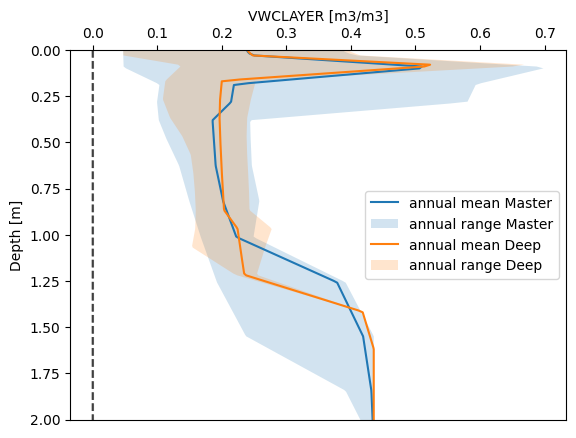

In [8]:
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
px = 1; py = 1
VWCLAYER, t_units = load_trsc_dataframe(var="VWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
VWCLAYER_master, t_units_master = load_trsc_dataframe(var="VWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

fig, ax = plt.subplots()

dep, avg, std, mn, mx = ds.seasonal_profile(VWCLAYER_master, LAYERDEPTH_master, LAYERDZ_master, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# fig, ax = plt.subplots()
x=dep
ax.plot(avg, dep, label="annual mean Master")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="annual range Master")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

dep, avg, std, mn, mx = ds.seasonal_profile(VWCLAYER, LAYERDEPTH, LAYERDZ, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
x=dep
ax.plot(avg, dep, label="annual mean Deep")
ax.fill_betweenx(dep, mn, mx, alpha=0.2, label="annual range Deep")
ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

ax.xaxis.tick_top()
ax.set_xlabel(f"VWCLAYER [{t_units['var_units']}]")
ax.xaxis.set_label_position('top') 

ax.set_ylabel(f"Depth [{ld_units['var_units']}]")
ax.set_ylim(0, 2)
ax.invert_yaxis()
ax.legend()

Trying to open:  output/IWCLAYER_monthly_tr.nc
Trying to open:  output/IWCLAYER_monthly_sc.nc
Trying to open:  output/IWCLAYER_monthly_tr.nc
Trying to open:  output/IWCLAYER_monthly_sc.nc
Trying to open:  output/LWCLAYER_monthly_tr.nc
Trying to open:  output/LWCLAYER_monthly_sc.nc
Trying to open:  output/LWCLAYER_monthly_tr.nc
Trying to open:  output/LWCLAYER_monthly_sc.nc


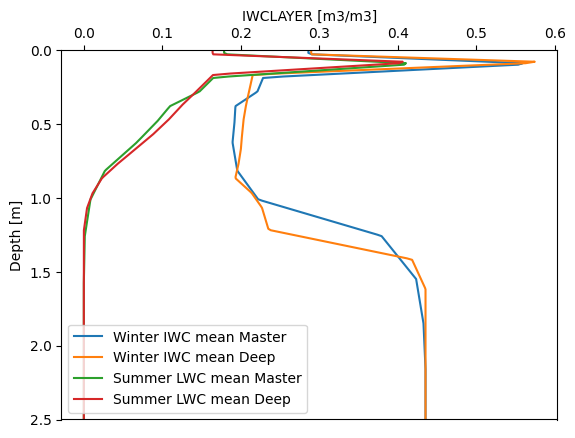

In [32]:
os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
px = 1; py = 1
IWCLAYER, t_units = load_trsc_dataframe(var="IWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
IWCLAYER_master, t_units_master = load_trsc_dataframe(var="IWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

fig, ax = plt.subplots()

dep, avg, std, mn, mx = ds.seasonal_profile(IWCLAYER_master, LAYERDEPTH_master, LAYERDZ_master, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Dec'])
# fig, ax = plt.subplots()
x=dep
ax.plot(avg, dep, label="Winter IWC mean Master")
# ax.fill_betweenx(dep, mn, mx, alpha=0.2)
# ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

dep, avg, std, mn, mx = ds.seasonal_profile(IWCLAYER, LAYERDEPTH, LAYERDZ, 0.01, '2000-2010', 
                    ['Jan', 'Feb', 'Dec'])
x=dep
ax.plot(avg, dep, label="Winter IWC mean Deep")
# ax.fill_betweenx(dep, mn, mx, alpha=0.2)
# ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

###

os.chdir('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/')
px = 1; py = 1
LWCLAYER, t_units = load_trsc_dataframe(var="LWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/')
LWCLAYER_master, t_units_master = load_trsc_dataframe(var="LWCLAYER", timeres='monthly', px_y=py,
                                                 px_x=px, fileprefix='output')

dep, avg, std, mn, mx = ds.seasonal_profile(LWCLAYER_master, LAYERDEPTH_master, LAYERDZ_master, 0.01, '2000-2010', 
                    ['Jun', 'Jul', 'Aug'])
# fig, ax = plt.subplots()
x=dep
ax.plot(avg, dep, label="Summer LWC mean Master")
# ax.fill_betweenx(dep, mn, mx, alpha=0.2)
# ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

dep, avg, std, mn, mx = ds.seasonal_profile(LWCLAYER, LAYERDEPTH, LAYERDZ, 0.01, '2000-2010', 
                    ['Jun', 'Jul', 'Aug'])
x=dep
ax.plot(avg, dep, label="Summer LWC mean Deep")
# ax.fill_betweenx(dep, mn, mx, alpha=0.2)
# ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)

###

ax.xaxis.tick_top()
ax.set_xlabel(f"IWCLAYER [{t_units['var_units']}]")
ax.xaxis.set_label_position('top') 

ax.set_ylabel(f"Depth [{ld_units['var_units']}]")
ax.set_ylim(0, 2.5)
ax.invert_yaxis()
ax.legend(loc='lower left')

In [22]:
LWC_master

0         1         2         3         4         5   \
1901-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1901-02-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1901-03-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1901-04-01  0.001876  0.001876  0.000000  0.000000  0.000000  0.000000   
1901-05-01  0.182563  0.182563  0.162383  0.198477  0.011592  0.000000   
...              ...       ...       ...       ...       ...       ...   
2100-08-01  0.243410  0.243410  0.259841  0.532918  0.495101  0.245407   
2100-09-01  0.250658  0.250658  0.257308  0.531765  0.500777  0.239570   
2100-10-01  0.256100  0.269072  0.276766  0.546896  0.514971  0.238737   
2100-11-01  0.000000  0.042029  0.091492  0.425284  0.514792  0.240412   
2100-12-01  0.000000  0.000000  0.000000  0.021145  0.395303  0.240408   

                  6         7         8         9   ...        12        13  \
1901-01-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1901-02-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1901-03-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1901-04-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1901-05-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
...              ...       ...       ...       ...  ...       ...       ...   
2100-08-01  0.246128  0.247230  0.248558  0.250626  ...  0.255195  0.259705   
2100-09-01  0.240638  0.241944  0.243378  0.245574  ...  0.255284  0.260880   
2100-10-01  0.239303  0.240078  0.241024  0.242662  ...  0.252736  0.259250   
2100-11-01  0.240938  0.241579  0.242325  0.243590  ...  0.252709  0.259188   
2100-12-01  0.240934  0.241577  0.242325  0.243590  ...  0.252709  0.259188   

                  14        15        16        17        18        19   20  \
1901-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
1901-02-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
1901-03-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
1901-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
1901-05-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
...              ...       ...       ...       ...       ...       ...  ...   
2100-08-01  0.266148  0.275009  0.291554  0.358901  0.435407  0.435407  0.0   
2100-09-01  0.268025  0.277470  0.294851  0.375496  0.435407  0.435407  0.0   
2100-10-01  0.267449  0.277968  0.296635  0.388820  0.435407  0.435407  0.0   
2100-11-01  0.267488  0.278181  0.297095  0.392342  0.435407  0.435407  0.0   
2100-12-01  0.267488  0.278181  0.297095  0.392342  0.435407  0.435407  0.0   

             21  
1901-01-01  0.0  
1901-02-01  0.0  
1901-03-01  0.0  
1901-04-01  0.0  
1901-05-01  0.0  
...         ...  
2100-08-01  0.0  
2100-09-01  0.0  
2100-10-01  0.0  
2100-11-01  0.0  
2100-12-01  0.0  

[2400 rows x 22 columns]

# Data synthesized by linear interpolation to compare by layer

Using Output_sythesis_Valeria.sh and Layer_var_synth.py scripts, we interpolated to compare across layers 

Usage: edit vars in sh script, and timeres in fsoil file in py script. Then run
$bash deep_soil_runs/Output_synthesis_Valeria.sh

Each "layer" in the below loaded data sets corresponds to each of the chosen depths

0- 5cm

1- 10cm

2- 100cm

3- 200 cm

# Temperature Profiles

build a temperature profile for the two TEEM versions (master and deep soil) for two seasonal periods: 
    June-July-August averages and January-February-March averages and for two time periods: 
    
 vertical pattern of soil temp (average by layer), y axis depth, x axis soil temp - outputs from master and deep soil
    
    the 2010-2015 period 
    the 2095-2100 period. 
    
    Both plots would be y-axis = depth (m) and x-axis = soil temperature (oC)
    four lines 
        - two for the summer averages for the two TEM versions (master= red solid line and deep soil = red dotted line)
        - 2 for the winter averages  for the two TEM versions (master= blue solid line and deep soil = blue dotted line). 

### Temp vars:
TLAYER,Temperature by layer,degree_C,,,invalid,invalid,invalid,invalid,double,
TMINEA,Temperature top mineral,degree_C,,,,invalid,invalid,invalid,double,
TMINEB,Temperature middle mineral,degree_C,,,,invalid,invalid,invalid,double,
TMINEC,Temperature bottom mineral,degree_C,,,,invalid,invalid,invalid,double,
    - TMINE vars are for a single depth - don't need to synthesize them to compare across different layer depths 

Depth vars:
LAYERDEPTH,Layer depth from the surface,m,,,invalid,invalid,invalid,invalid,double,
LAYERDZ,Thickness of layer,m,,,invalid,invalid,invalid,invalid,double,

In [3]:
#Ben's interp. function:
#Var is a pandas DataFrame

import numpy as np
import pandas as pd

def layer_interp(Var, Depth, Thickness, resolution):
    
    df_interp = pd.DataFrame(index=Var.index, columns=range(resolution), data=[])

    for date in Var.index:
        
        xp = Depth.loc[date] + Thickness.loc[date]/2
        x=np.linspace(min(xp), max(xp), resolution)
        fp = Var.loc[date]
        
        df_interp.loc[date]=np.interp(x,xp,fp)
    
    df_interp.columns = x
    df_interp.replace(-9999.0, np.nan)
    
    return df_interp

output_var='TLAYER'
resolution=10
y=1
x=1

os.chdir('/data/workflows/BNZ_deep_soil/control_allout_monthly_11px')
control=load_trsc_dataframe(var=output_var, timeres='monthly', px_y=y, px_x=x, fileprefix='output')
depth=load_trsc_dataframe('LAYERDEPTH', timeres='monthly', px_y=y, px_x=x, fileprefix='output')
thick=load_trsc_dataframe('LAYERDZ', timeres='monthly', px_y=y, px_x=x, fileprefix='output')

os.chdir('/data/workflows/BNZ_deep_soil/experiment_allout_monthly_11px')
experiment=load_trsc_dataframe(var=output_var, timeres='monthly', px_y=y, px_x=x, fileprefix='output')

# df_interp=layer_interp(experiment, depth, thick, resolution)
# df_interp

In [134]:
# Load interpolated data from synthesis folders, load as xarray datasets, convert to pandas df

#master branch run
m_tr = xr.open_dataset('/data/workflows/MD_deep_soil/control_allout_monthly_11px/output/synthesis/TLAYER_std_depth_monthly_tr.nc')
m_sc = xr.open_dataset('/data/workflows/MD_deep_soil/control_allout_monthly_11px/output/synthesis/TLAYER_std_depth_monthly_sc.nc')
m = xr.concat([m_tr, m_sc], dim="time")

#deep soil branch run
ds_tr = xr.open_dataset('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/output/synthesis/TLAYER_std_depth_monthly_tr.nc')
ds_sc = xr.open_dataset('/data/workflows/MD_deep_soil/experiment_allout_monthly_11px/output/synthesis/TLAYER_std_depth_monthly_sc.nc')
ds = xr.concat([ds_tr, ds_sc], dim="time")

m = m.to_dataframe()
ds = ds.to_dataframe()

In [135]:
ds

z  type     TLAYER
time       x y layer                        
1901-01-01 1 1 0      0.010   0.0 -11.821225
               1      0.020   1.0 -11.799016
               2      0.030   1.0 -11.776806
               3      0.040   1.0 -11.754597
               4      0.050   2.0 -11.731872
...                     ...   ...        ...
2100-12-01 1 1 218    4.500   3.0   2.027669
               219    4.625   3.0   1.994378
               220    4.750   3.0   1.966875
               221    4.875   3.0   1.966875
               222    5.000   3.0   1.966875

[535200 rows x 3 columns]

In [136]:
# Filter for the desired time ranges
time_range_1 = pd.date_range('2010-01-01', '2015-12-31')
time_range_2 = pd.date_range('2095-01-01', '2100-12-31')

# Filter for the seasonal periods
summer = [6, 7, 8]  # June-July-August
winter = [1, 2, 3]  # January-February-March

# Select the data for the specified time ranges and seasonal periods
m_range_1 = m.loc[(m.index.get_level_values('time').isin(time_range_1))]
m_range_2 = m.loc[(m.index.get_level_values('time').isin(time_range_2))]
ds_range_1 = ds.loc[(ds.index.get_level_values('time').isin(time_range_1))]
ds_range_2 = ds.loc[(ds.index.get_level_values('time').isin(time_range_2))]

#for time range 1, separate by season
ds_summer_1 = ds_range_1[ds_range_1.index.get_level_values('time').month.isin(summer)]
ds_winter_1 = ds_range_1[ds_range_1.index.get_level_values('time').month.isin(winter)]
m_summer_1 = m_range_1[m_range_1.index.get_level_values('time').month.isin(summer)]
m_winter_1 = m_range_1[m_range_1.index.get_level_values('time').month.isin(winter)]

#for time range 2, separate by season
ds_summer_2 = ds_range_2[ds_range_2.index.get_level_values('time').month.isin(summer)]
ds_winter_2 = ds_range_2[ds_range_2.index.get_level_values('time').month.isin(winter)]
m_summer_2 = m_range_2[m_range_2.index.get_level_values('time').month.isin(summer)]
m_winter_2 = m_range_2[m_range_2.index.get_level_values('time').month.isin(winter)]

In [137]:
# Calculate the average temperature by layer for each seasonal period and time range
ds_avg_temp_summer_1 = ds_summer_1.groupby('z')['TLAYER'].mean()
ds_avg_temp_winter_1 = ds_winter_1.groupby('z')['TLAYER'].mean()
ds_avg_temp_summer_2 = ds_summer_2.groupby('z')['TLAYER'].mean()
ds_avg_temp_winter_2 = ds_winter_2.groupby('z')['TLAYER'].mean()

m_avg_temp_summer_1 = m_summer_1.groupby('z')['TLAYER'].mean()
m_avg_temp_winter_1 = m_winter_1.groupby('z')['TLAYER'].mean()
m_avg_temp_summer_2 = m_summer_2.groupby('z')['TLAYER'].mean()
m_avg_temp_winter_2 = m_winter_2.groupby('z')['TLAYER'].mean()

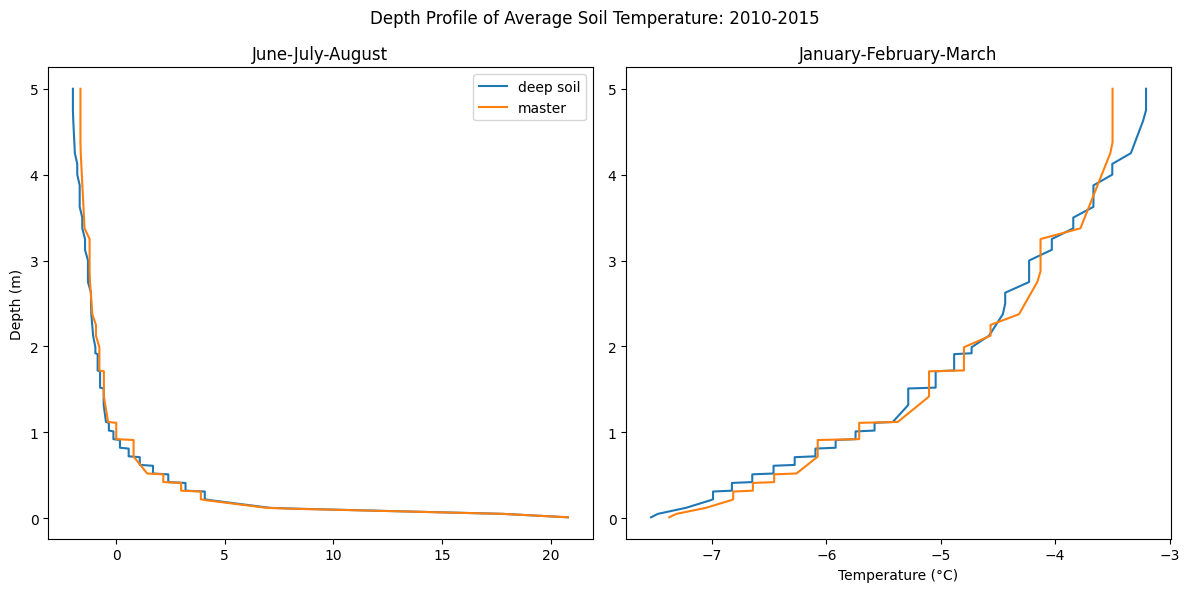

In [138]:
# Plot the average temperature by layer for the first seasonal period

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(ds_avg_temp_summer_1, ds_avg_temp_summer_1.index, label='deep soil')
ax[0].plot(m_avg_temp_summer_1, m_avg_temp_summer_1.index, label='master')

ax[1].plot(ds_avg_temp_winter_1, ds_avg_temp_winter_1.index, label='deep soil')
ax[1].plot(m_avg_temp_winter_1, m_avg_temp_winter_1.index, label='master')

# Set the plot title and axis labels
ax[0].set_title('June-July-August')
ax[0].set_ylabel('Depth (m)')
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('January-February-March')

# Add a legend
ax[0].legend()
# ax[0,1].legend()
# plt.legend()

# Display the plot
plt.suptitle('Depth Profile of Average Soil Temperature: 2010-2015')
plt.tight_layout()

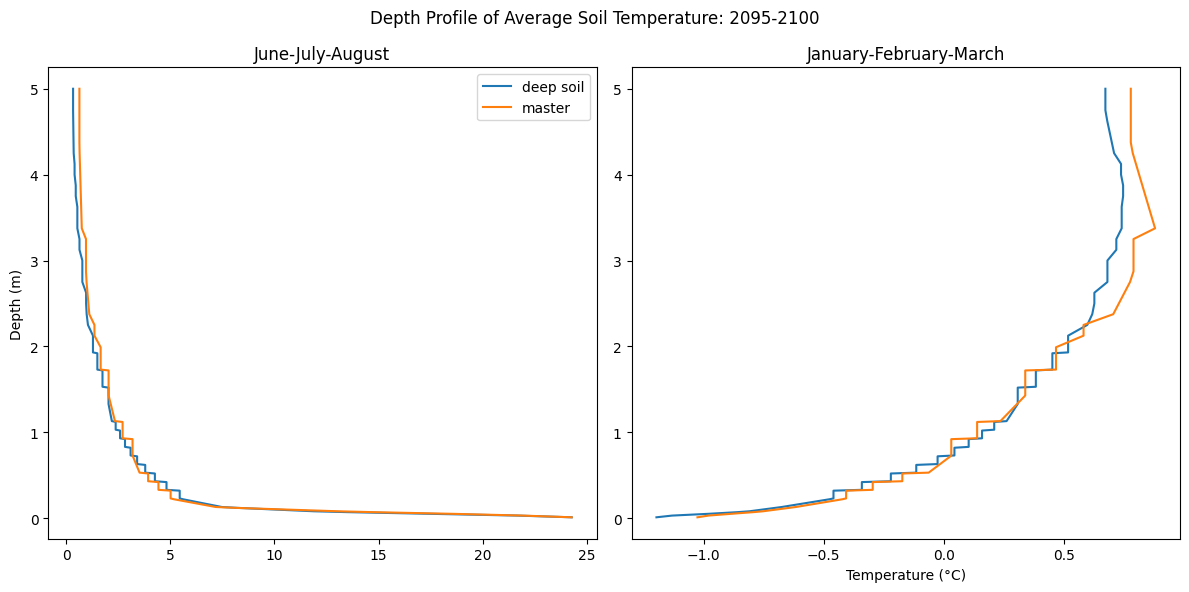

In [139]:
# Plot the average temperature by layer for the second time period
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(ds_avg_temp_summer_2, ds_avg_temp_summer_2.index, label='deep soil')
ax[0].plot(m_avg_temp_summer_2, m_avg_temp_summer_2.index, label='master')

ax[1].plot(ds_avg_temp_winter_2, ds_avg_temp_winter_2.index, label='deep soil')
ax[1].plot(m_avg_temp_winter_2, m_avg_temp_winter_2.index, label='master')

# Set the plot title and axis labels
ax[0].set_title('June-July-August')
ax[0].set_ylabel('Depth (m)')
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('January-February-March')

# Add a legend
ax[0].legend()
# ax[0,1].legend()
# plt.legend()

# Display the plot
plt.suptitle('Depth Profile of Average Soil Temperature: 2095-2100')
plt.tight_layout()

In [129]:
np.arange(0, 2, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [67]:
#To use the load_trsc_dataframe function in output_utils.py 
# not that setting the units in the netcdf files isnt enough - the shape of the synthesized data 
# doesn't match the shape expected by the function

m = nc.Dataset('/data/workflows/MD_deep_soil/control_allout_monthly_11px/output/synthesis/TLAYER_monthly_tr.nc', 'r+')
TLAYER = m.variables['TLAYER']
TLAYER.setncattr('units', 'degree_C')
m.close()

m2 = nc.Dataset('/data/workflows/MD_deep_soil/control_allout_monthly_11px/output/synthesis/TLAYER_monthly_sc.nc', 'r+')
TLAYER = m2.variables['TLAYER']
TLAYER.setncattr('units', 'degree_C')
m2.close()

os.chdir('/data/workflows/MD_deep_soil/control_allout_monthly_11px/output/')
df, meta = load_trsc_dataframe(var='TLAYER', timeres='monthly',px_y=1, px_x=1, fileprefix='synthesis')

Trying to open:  synthesis/TLAYER_monthly_tr.nc
Trying to open:  synthesis/TLAYER_monthly_sc.nc


ValueError: cannot reshape array of size 0 into shape (2400,1)

In [17]:
#Plot master branch run: TLAYER_std_depth_yearly_tr.nc

m = nc.Dataset('/data/workflows/MD_deep_soil/control_allout_yearly/output/synthesis/TLAYER_std_depth_yearly_tr.nc')
ds = nc.Dataset('/data/workflows/MD_deep_soil/experiment_allout_yearly/output/synthesis/TLAYER_std_depth_yearly_tr.nc')
layer=3

fig, ax = plt.subplots(1,1,figsize=(15, 5))
ds.plot_synth_data(m,'TLAYER',0,0,layer,2000)
ds.plot_synth_data(ds,'TLAYER',0,0,layer,2000)

ax.legend(['Master (unchanged)', 'Deep Soil'])


# diff=df_yearly_m-df_yearly
# plt.plot(diff.loc['1950':'2100'].index, diff.loc['1950':'2100'][3], label='TLAYER')

FileNotFoundError: [Errno 2] No such file or directory: b'/data/workflows/MD_deep_soil/control_allout_yearly/output/synthesis/TLAYER_std_depth_yearly_tr.nc'

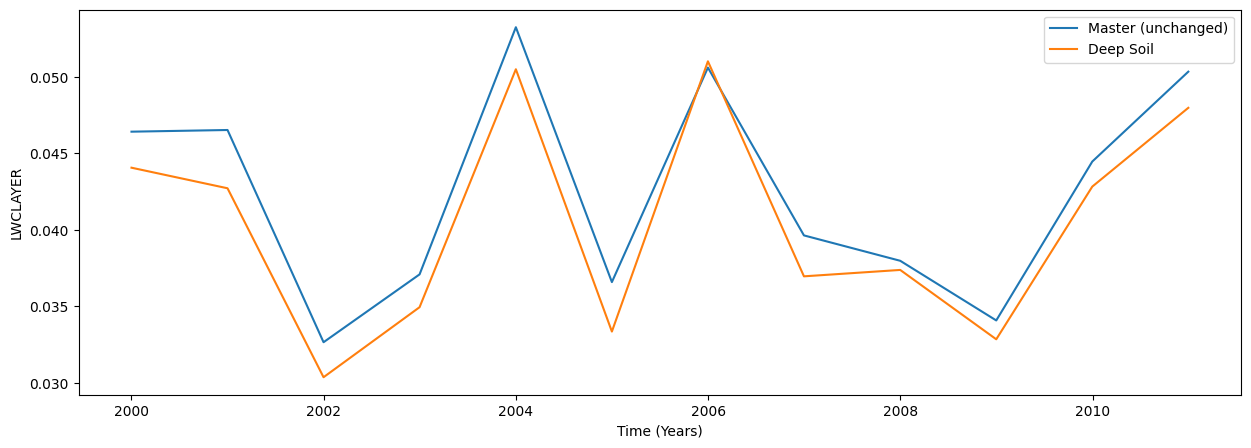

In [109]:
#Plot LWC Layer

m = nc.Dataset('/data/workflows/MD_deep_soil/control_allout_yearly/output/synthesis/LWCLAYER_std_depth_yearly_tr.nc')
ds = nc.Dataset('/data/workflows/MD_deep_soil/experiment_allout_yearly/output/synthesis/LWCLAYER_std_depth_yearly_tr.nc')
layer=2

fig, ax = plt.subplots(1,1,figsize=(15, 5))
ds.plot_synth_data(m,'LWCLAYER',0,0,layer,2000,2010)
ds.plot_synth_data(ds,'LWCLAYER',0,0,layer,2000,2010)

ax.legend(['Master (unchanged)', 'Deep Soil'])

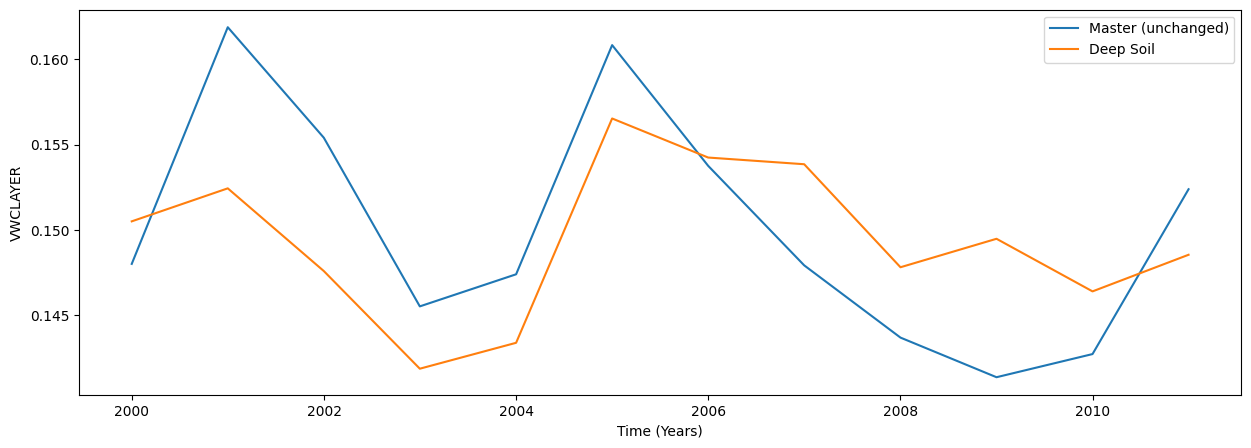

In [111]:
#Plot VWC Layer

m = nc.Dataset('/data/workflows/MD_deep_soil/control_allout_yearly/output/synthesis/VWCLAYER_std_depth_yearly_tr.nc')
ds = nc.Dataset('/data/workflows/MD_deep_soil/experiment_allout_yearly/output/synthesis/VWCLAYER_std_depth_yearly_tr.nc')
layer=2

fig, ax = plt.subplots(1,1,figsize=(15, 5))
ds.plot_synth_data(m,'VWCLAYER',0,0,layer,2000,2010)
ds.plot_synth_data(ds,'VWCLAYER',0,0,layer,2000,2010)

ax.legend(['Master (unchanged)', 'Deep Soil'])

Text(0.5, 1.0, 'Interpolated VWCLAYER, Pixel 0,0')

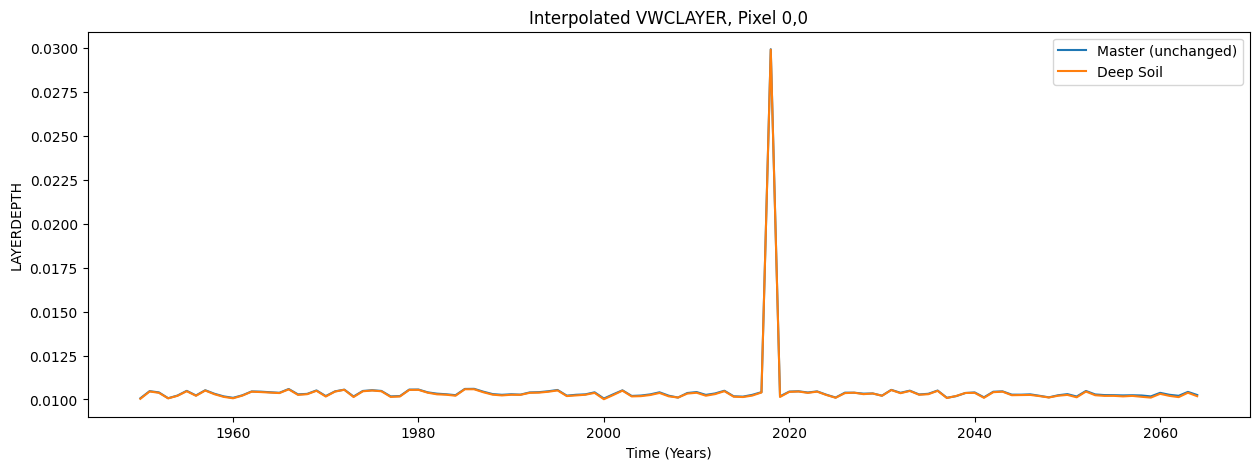

In [144]:
#Plot VWC Layer, Interpolated

m = nc.Dataset('/data/workflows/MD_deep_soil/control_allout_yearly/output/synthesis/LAYERDEPTH_std_depth_yearly_tr.nc')
ds = nc.Dataset('/data/workflows/MD_deep_soil/experiment_allout_yearly/output/synthesis/LAYERDEPTH_std_depth_yearly_tr.nc')
layer=0

fig, ax = plt.subplots(1,1,figsize=(15, 5))
ds.plot_synth_data(m,'LAYERDEPTH',0,0,layer,1950,2100)
ds.plot_synth_data(ds,'LAYERDEPTH',0,0,layer,1950,2100)

ax.legend(['Master (unchanged)', 'Deep Soil'])
plt.title('Interpolated VWCLAYER, Pixel 0,0')